In [166]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import utils
import time
#import joblib
from scipy.stats import pearsonr  #gaussian_kde, pearsonr
import datetime
import cartopy.crs as ccrs
import random
import geopandas as gpd

In [2]:
# Data paths
plot_dir  = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\'
#fn =  'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time1_lat2_lon3_min3_dist100.nc' 
fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_oco2_v11.1_20140906_20200630_time2_lat2_lon3_min3_dist300_qf=all_parallel_airmass_sza.nc'
####tccon_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_tccon_time1_lat2_lon3_min3_dist100.nc'
#tccon_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\TCCON_TEST_NEWEST.nc'
#tccon_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_tccon_ggg2020_time2_lat2.5_lon5.0_min2.nc'
tccon_fn = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\match_gosat_v9_tccon_ggg2020_time1_lat2.5_lon5.0_min15.nc'

In [3]:
# Load GOSAT-OCO collocated data
colloc_data_xr = xr.open_dataset(fn) 
colloc_data = colloc_data_xr.to_dataframe()
colloc_data['gosat_sounding_id'] = colloc_data.index
print(f'{colloc_data.shape[0]} GOSAT-OCO colloacated soundings')
colloc_data = colloc_data[colloc_data['gosat_xco2_quality_flag']==0]  # only compare QF=0
print(f'{colloc_data.shape[0]} QF=0 colloacated soundings')

431616 GOSAT-OCO colloacated soundings
205033 QF=0 colloacated soundings


In [4]:
land_h_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 1) & 
                                        (colloc_data['gosat_gain'] == 'H')]
land_m_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 1) & 
                                        (colloc_data['gosat_gain'] == 'M')]
ocean_h_colloc = colloc_data[(colloc_data['gosat_retrieval_surface_type'] == 0) & 
                                        (colloc_data['gosat_gain'] == 'H')]

In [5]:
# Load TCCON-GOSAT collocated data
tccon_gosat_collocations = xr.open_dataset(tccon_fn)
tccon_gosat_collocations = tccon_gosat_collocations.to_dataframe()
print(f'{tccon_gosat_collocations.shape[0]} TCCON-GOSAT colloacated soundings')
tccon_gosat_collocations = tccon_gosat_collocations[tccon_gosat_collocations['gosat_xco2_quality_flag']==0]  # only compare QF=0
print(f'{tccon_gosat_collocations.shape[0]} QF=0 colloacated soundings')

42221 TCCON-GOSAT colloacated soundings
21092 QF=0 colloacated soundings


In [6]:
# Remap Armstrong and Dryden to Edwards   
tccon_gosat_collocations.loc[tccon_gosat_collocations['tccon_site'] == 'Armstrong', 'tccon_site'] = 'Edwards'
tccon_gosat_collocations.loc[tccon_gosat_collocations['tccon_site'] == 'Dryden', 'tccon_site'] = 'Edwards'

In [8]:
land_h_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 1) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'H')]
land_m_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 1) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'M')]
ocean_h_tccon = tccon_gosat_collocations[(tccon_gosat_collocations['gosat_retrieval_surface_type'] == 0) & 
                                        (tccon_gosat_collocations['gosat_gain'] == 'H')]

In [11]:
# All GOSAT soundings collocated to TCCON
gosat_gpd = gpd.GeoDataFrame(
        tccon_gosat_collocations,
        geometry=gpd.points_from_xy(tccon_gosat_collocations.gosat_longitude, tccon_gosat_collocations.gosat_latitude),
        crs="EPSG:4326" # WGS84 geographic coordinate system
)

# TCCON stations
tccon_gpd = gpd.GeoDataFrame(
        tccon_gosat_collocations,
        geometry=gpd.points_from_xy(tccon_gosat_collocations.lon, tccon_gosat_collocations.lat),
        crs="EPSG:4326" # WGS84 geographic coordinate system
)

# All QF = 0 GOSAT data (collocated to OCO-2)
gosat_full_gpd = gpd.GeoDataFrame(
        colloc_data,
        geometry=gpd.points_from_xy(colloc_data.gosat_longitude, colloc_data.gosat_latitude),
        crs="EPSG:4326" # WGS84 geographic coordinate system
)

Spatial validation of TCCON-GOSAT collocations

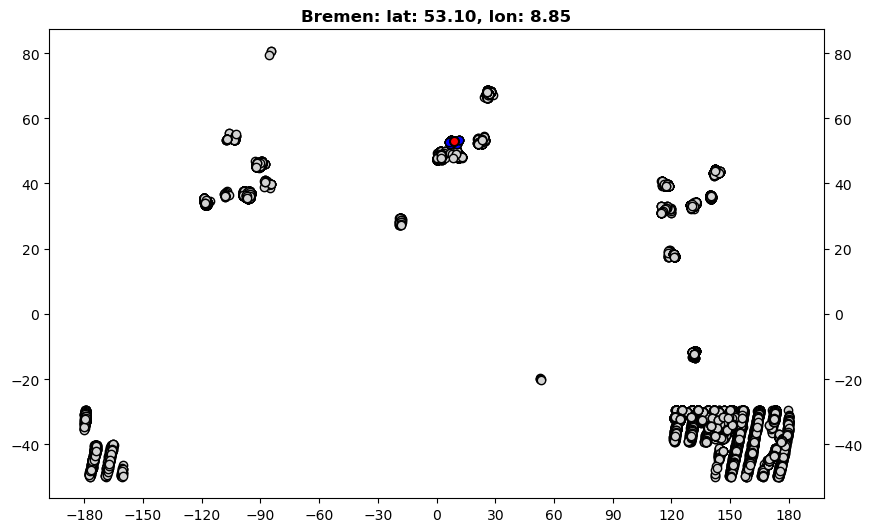

In [13]:
# Plot which of the TCCON-GOSAT collocated data was collocated to the specified site

site = 'Bremen'
tccon_site = tccon_gpd[tccon_gpd['tccon_site'] == site]
collocated_gosat = gosat_gpd[gosat_gpd['tccon_site'] == site]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gosat_gpd.plot(ax=ax, color='lightgray', edgecolor='black')
collocated_gosat.plot(ax=ax, color='blue', edgecolor='black')
tccon_site.plot(ax=ax, color='red', edgecolor='black')
plt.title(f'{tccon_site.iloc[0]["tccon_site"]}: lat: {tccon_site.iloc[0]["lat"]:.2f}, lon: {tccon_site.iloc[0]["lon"]:.2f}', fontweight='bold')
ax.set_xticks(np.arange(-180, 190, 30)); 
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

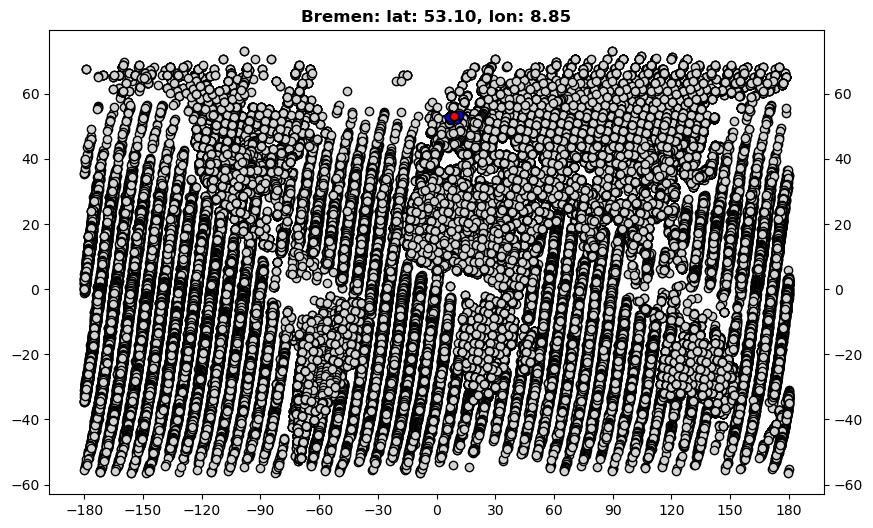

In [14]:
# Plot which of the GOSAT-OCO-2 collocated data is collocated to the specified TCCON site

site = 'Bremen'
tccon_site = tccon_gpd[tccon_gpd['tccon_site'] == site]
collocated_gosat = gosat_gpd[gosat_gpd['tccon_site'] == site]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gosat_full_gpd.plot(ax=ax, color='lightgray', edgecolor='black')
collocated_gosat.plot(ax=ax, color='blue', edgecolor='black')
tccon_site.plot(ax=ax, color='red', edgecolor='black')
plt.title(f'{tccon_site.iloc[0]["tccon_site"]}: lat: {tccon_site.iloc[0]["lat"]:.2f}, lon: {tccon_site.iloc[0]["lon"]:.2f}', fontweight='bold')
ax.set_xticks(np.arange(-180, 190, 30)); 
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

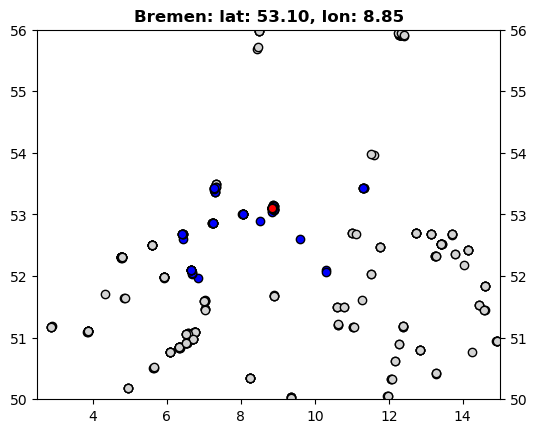

In [16]:
# Zoomed in version of above plot

site = 'Bremen'
tccon_site = tccon_gpd[tccon_gpd['tccon_site'] == site]
collocated_gosat = gosat_gpd[gosat_gpd['tccon_site'] == site]

fig, ax = plt.subplots()
gosat_full_gpd.plot(ax=ax, color='lightgray', edgecolor='black')
collocated_gosat.plot(ax=ax, color='blue', edgecolor='black')
tccon_site.plot(ax=ax, color='red', edgecolor='black')
plt.title(f'{tccon_site.iloc[0]["tccon_site"]}: lat: {tccon_site.iloc[0]["lat"]:.2f}, lon: {tccon_site.iloc[0]["lon"]:.2f}', fontweight='bold')
plt.ylim(50.0, 56.0)  # set this manually per site
plt.xlim(2.5, 15.0)  # set this manually per site
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

Plot TCCON results

In [12]:
# Assing markers for each TCCON site

markers =  {'Eureka': 'D',
            'Sodankylä': '^',
            'East Trout Lake': 'H',
            'Bremen': '^',
            'Bialystok': '>',
            'Karlsruhe': '<',
            'Paris': '>',
            'Park Falls': '>',
            'Orléans': '<',
            'Garmisch': '*',
            'Rikubetsu': 'o',
            'Indianapolis': 'o',
            'Xianghe':  'v',
            'Four Corners': '*',
            'Lamont': 'D',
            'Tsukuba': 'o',
            'Nicosia': '<',
            'Edwards': '^',
            'Dryden':'^',
            'JPL': '<',
            'Caltech': '<',
            'Saga': 'v',
            'Hefei': '<',
            'Burgos': 'H',
            'Darwin': 'o',
            'Wollongong': '<', 
            'Lauder':  'v'
            }

markerfacecolors = {'Eureka': 'b',
                    'Sodankylä': 'darkblue',
                    'East Trout Lake': 'royalblue',
                    'Bremen': 'dodgerblue',
                    'Bialystok': 'steelblue',
                    'Karlsruhe': 'cadetblue',
                    'Paris': 'c',
                    'Park Falls': 'teal',
                    'Orléans': 'mediumturquoise', 
                    'Garmisch': 'mediumseagreen',
                    'Rikubetsu': 'lightgreen',
                    'Indianapolis': 'greenyellow',
                    'Xianghe': 'yellowgreen',
                    'Four Corners': 'olivedrab',
                    'Lamont': 'y',
                    'Tsukuba': 'yellow',
                    'Nicosia': 'gold',
                    'Edwards': 'goldenrod',
                    'Dryden': 'goldenrod',
                    'JPL': 'sandybrown',
                    'Caltech': 'sandybrown',
                    'Saga': 'orange',
                    'Hefei': 'darkorange',
                    'Burgos': 'orangered',
                    'Darwin': 'r',
                    'Wollongong': 'firebrick',
                    'Lauder': 'darkred'
                    }

site_order = ['Eureka', 'Sodankylä', 'East Trout Lake', 'Bremen', 'Bialystok', 'Karlsruhe', 'Paris', 'Park Falls',
              'Orléans', 'Garmisch', 'Rikubetsu', 'Indianapolis', 'Xianghe', 'Four Corners', 'Lamont', 'Tsukuba',
              'Nicosia', 'Edwards', 'Dryden', 'JPL', 'Caltech', 'Saga', 'Hefei', 'Burgos', 'Darwin', 'Wollongong',
              'Lauder']

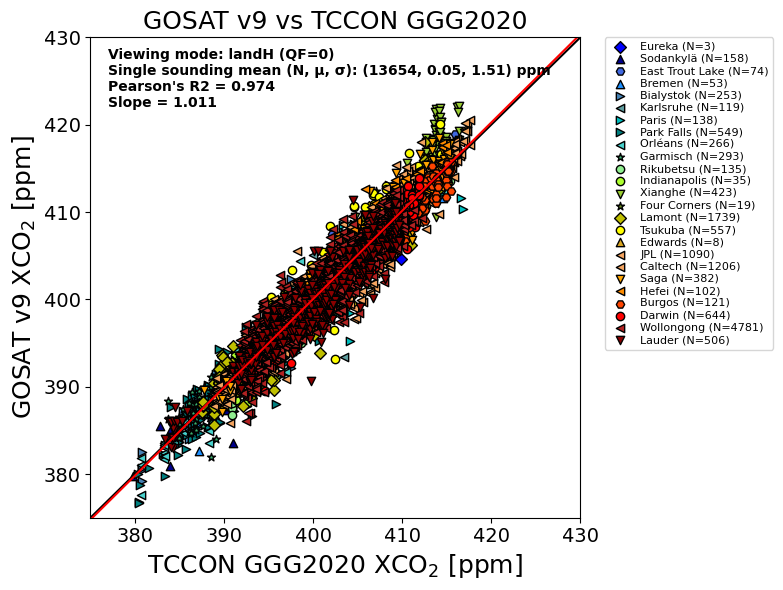

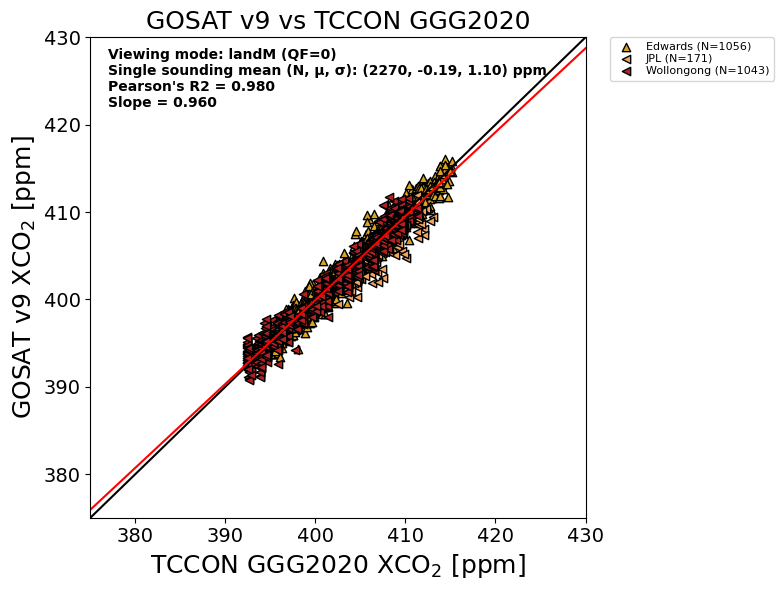

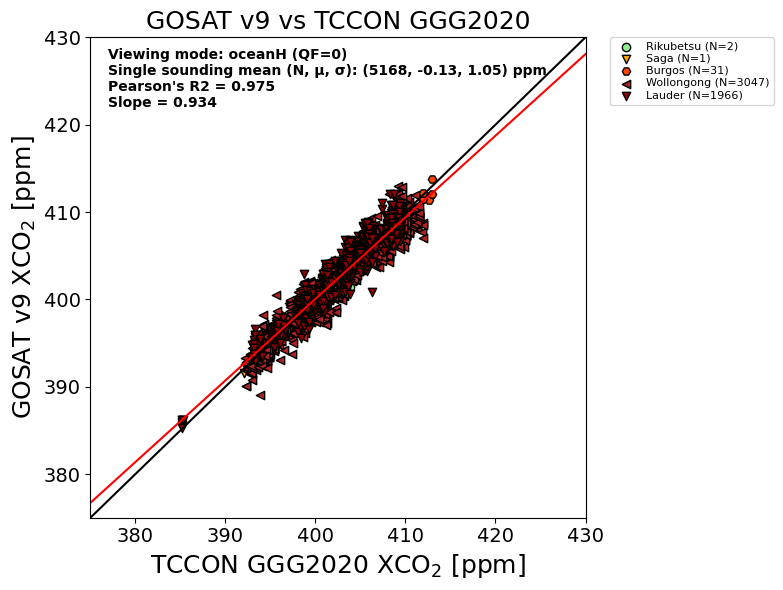

In [15]:
# TCCON versus BC GOSAT 

# LandH
single_sounding_diff_mean = (land_h_tccon['gosat_xco2'] - land_h_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (land_h_tccon['gosat_xco2'] - land_h_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(land_h_tccon['tccon_xco2_ak_corrected_mean'], land_h_tccon['gosat_xco2'])
slope, intercept = np.polyfit(land_h_tccon['tccon_xco2_ak_corrected_mean'], land_h_tccon['gosat_xco2'], 1)

fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(land_h_tccon[land_h_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                land_h_tccon[land_h_tccon['tccon_site']==site]['gosat_xco2'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={land_h_tccon[land_h_tccon['tccon_site']==site].shape[0]})")

ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: landH (QF=0) \nSingle sounding mean (N, μ, σ): \
({land_h_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)

# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')


print()
print()


# LandM
single_sounding_diff_mean = (land_m_tccon['gosat_xco2'] - land_m_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (land_m_tccon['gosat_xco2'] - land_m_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(land_m_tccon['tccon_xco2_ak_corrected_mean'], land_m_tccon['gosat_xco2'])
slope, intercept = np.polyfit(land_m_tccon['tccon_xco2_ak_corrected_mean'], land_m_tccon['gosat_xco2'], 1)

fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(land_m_tccon[land_m_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                land_m_tccon[land_m_tccon['tccon_site']==site]['gosat_xco2'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={land_m_tccon[land_m_tccon['tccon_site']==site].shape[0]})")
    
ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: landM (QF=0) \nSingle sounding mean (N, μ, σ): \
({land_m_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)

# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')

print()
print()

# OceanH
single_sounding_diff_mean = (ocean_h_tccon['gosat_xco2'] - ocean_h_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (ocean_h_tccon['gosat_xco2'] - ocean_h_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(ocean_h_tccon['tccon_xco2_ak_corrected_mean'], ocean_h_tccon['gosat_xco2'])
slope, intercept = np.polyfit(ocean_h_tccon['tccon_xco2_ak_corrected_mean'], ocean_h_tccon['gosat_xco2'], 1)


fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(ocean_h_tccon[ocean_h_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                ocean_h_tccon[ocean_h_tccon['tccon_site']==site]['gosat_xco2'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={ocean_h_tccon[ocean_h_tccon['tccon_site']==site].shape[0]})")

ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: oceanH (QF=0) \nSingle sounding mean (N, μ, σ): \
({ocean_h_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)
# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')

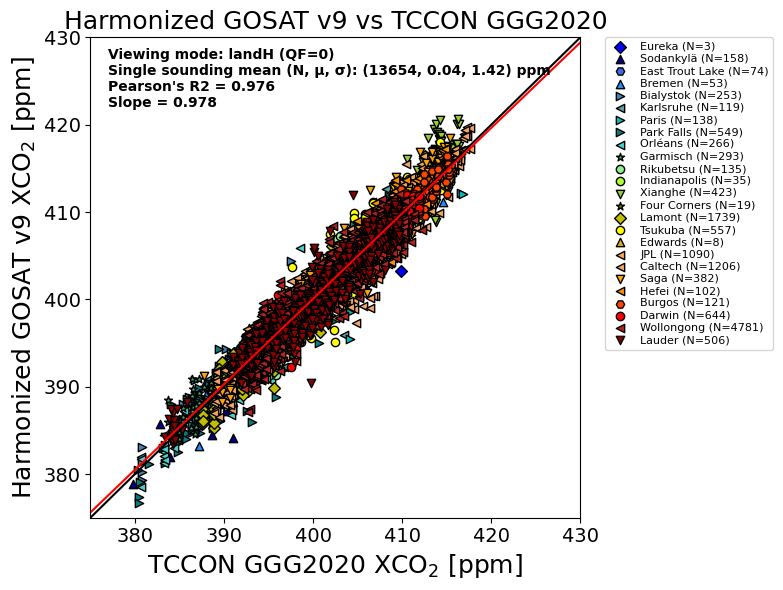

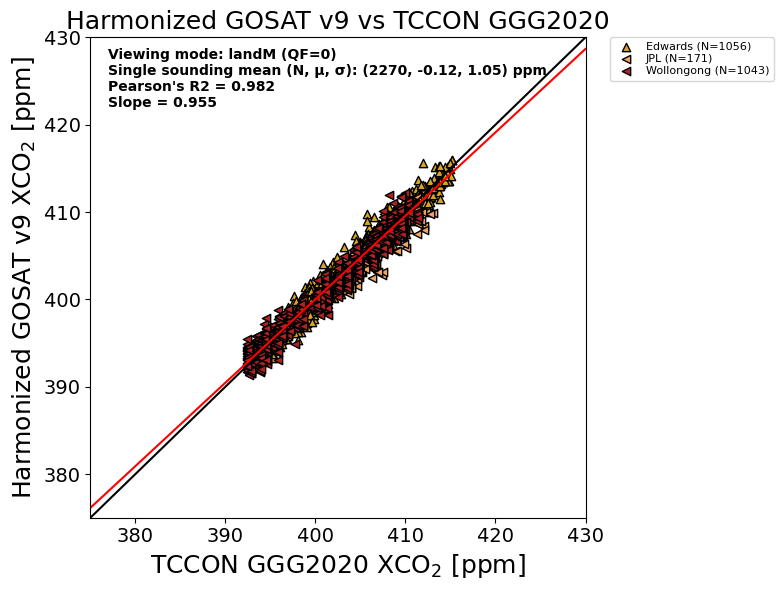

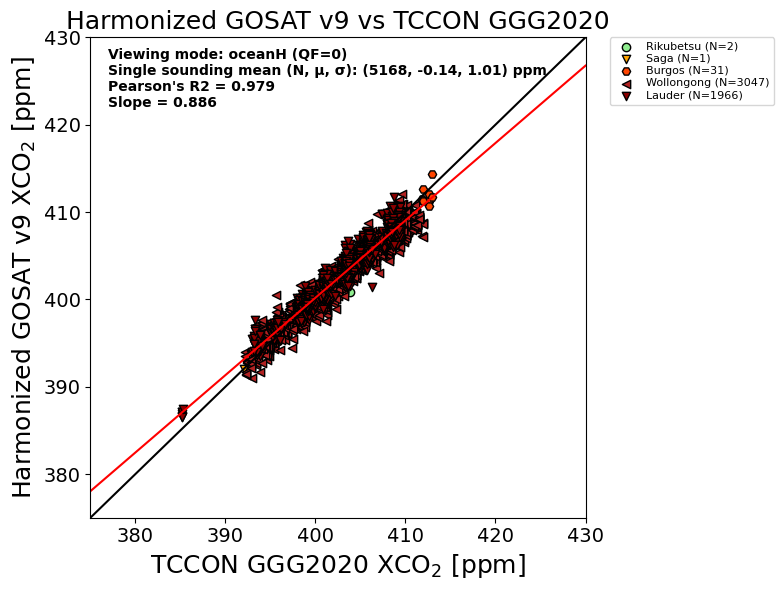

In [17]:
# TCCON versus harmonized GOSAT 

# LandH
single_sounding_diff_mean = (land_h_tccon['gosat_xco2_harmonized'] - land_h_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (land_h_tccon['gosat_xco2_harmonized'] - land_h_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(land_h_tccon['tccon_xco2_ak_corrected_mean'], land_h_tccon['gosat_xco2_harmonized'])
slope, intercept = np.polyfit(land_h_tccon['tccon_xco2_ak_corrected_mean'], land_h_tccon['gosat_xco2_harmonized'], 1)

fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(land_h_tccon[land_h_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                land_h_tccon[land_h_tccon['tccon_site']==site]['gosat_xco2_harmonized'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={land_h_tccon[land_h_tccon['tccon_site']==site].shape[0]})")

ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'Harmonized GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('Harmonized GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: landH (QF=0) \nSingle sounding mean (N, μ, σ): \
({land_h_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)

# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')

print()
print()


# LandM
single_sounding_diff_mean = (land_m_tccon['gosat_xco2_harmonized'] - land_m_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (land_m_tccon['gosat_xco2_harmonized'] - land_m_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(land_m_tccon['tccon_xco2_ak_corrected_mean'], land_m_tccon['gosat_xco2_harmonized'])
slope, intercept = np.polyfit(land_m_tccon['tccon_xco2_ak_corrected_mean'], land_m_tccon['gosat_xco2_harmonized'], 1)


fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(land_m_tccon[land_m_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                land_m_tccon[land_m_tccon['tccon_site']==site]['gosat_xco2_harmonized'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={land_m_tccon[land_m_tccon['tccon_site']==site].shape[0]})")

ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'Harmonized GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('Harmonized GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: landM (QF=0) \nSingle sounding mean (N, μ, σ): \
({land_m_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)
# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')

print()
print()

# OceanH
single_sounding_diff_mean = (ocean_h_tccon['gosat_xco2_harmonized'] - ocean_h_tccon['tccon_xco2_ak_corrected_mean']).mean()
single_sounding_diff_std = (ocean_h_tccon['gosat_xco2_harmonized'] - ocean_h_tccon['tccon_xco2_ak_corrected_mean']).std()
corr, _ = pearsonr(ocean_h_tccon['tccon_xco2_ak_corrected_mean'], ocean_h_tccon['gosat_xco2_harmonized'])
slope, intercept = np.polyfit(ocean_h_tccon['tccon_xco2_ak_corrected_mean'], ocean_h_tccon['gosat_xco2_harmonized'], 1)


fig, ax = plt.subplots(figsize=(8, 6))
for site in site_order:
    ax.scatter(ocean_h_tccon[ocean_h_tccon['tccon_site']==site]['tccon_xco2_ak_corrected_mean'], 
                ocean_h_tccon[ocean_h_tccon['tccon_site']==site]['gosat_xco2_harmonized'], 
                marker=markers[site], facecolor=markerfacecolors[site], edgecolor='black',
                label=f"{site} (N={ocean_h_tccon[ocean_h_tccon['tccon_site']==site].shape[0]})")

ax.set_xlim(375, 430)
ax.set_ylim(375, 430)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'TCCON GGG2020 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_ylabel(r'Harmonized GOSAT v9 $\text{XCO}_{2}$ [ppm]', fontsize=18)
ax.set_title('Harmonized GOSAT v9 vs TCCON GGG2020', fontsize=18)
ax.annotate(f"Viewing mode: oceanH (QF=0) \nSingle sounding mean (N, μ, σ): \
({ocean_h_tccon.shape[0]}, {single_sounding_diff_mean:.2f}, \
{single_sounding_diff_std:.2f}) ppm\nPearson's R2 = {corr:.3f}\nSlope = {slope:.3f}", xy=(377, 418), 
xytext=(377, 422), arrowprops=None, fontsize=10, fontweight='bold');
plt.legend(prop={'size': 8}, labelspacing=0.2, borderpad=0.5)

# Filter down sites to only keep non-empty ones
handles, labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
for handle, label in zip(handles, labels):
    if 'N=0' not in label:  # Check if the label is not empty
        filtered_handles.append(handle)
        filtered_labels.append(label)
# Place the legend outside the plot
ax.legend(filtered_handles, filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2,)
# Adjust layout to prevent legend overlap
plt.tight_layout()
x = np.linspace(375,430)
y = x 
ax.plot(x,y, color='black')
ax.axline((0,intercept), slope=slope, color='red'); #, linestyle='--')


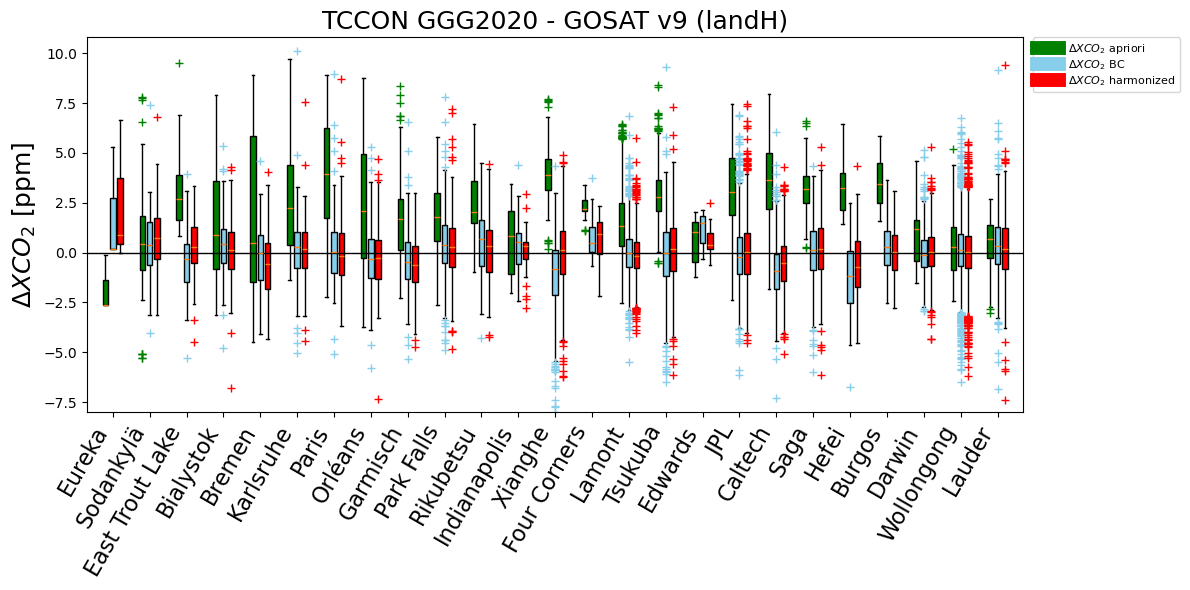

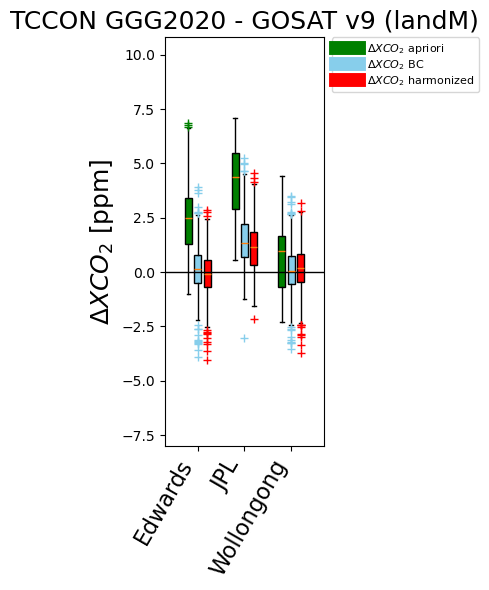

oceanH sites:
['Lauder' 'Saga' 'Wollongong' 'Izaña' 'Reunion Island' 'Rikubetsu'
 'Burgos']


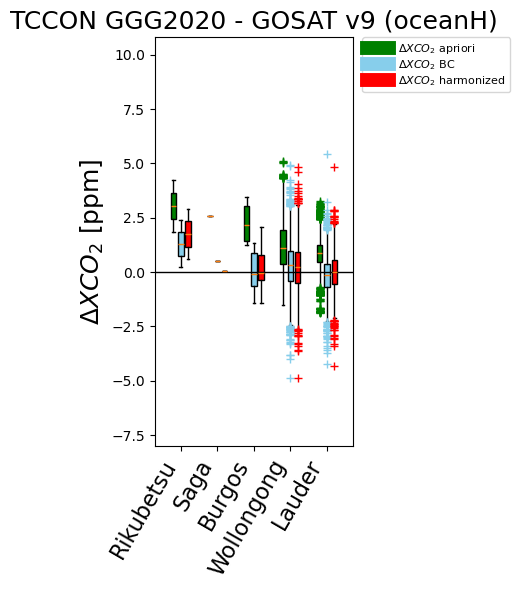

In [26]:
# Box and whisker plots - landH, landM, oceanH

positions = []
pos = 0
width = 0.2  # spacing between grouped boxes

categories = ['gosat_xco2_apriori','gosat_xco2','gosat_xco2_harmonized']
colors = {'gosat_xco2_apriori':'green', 'gosat_xco2':'skyblue', 'gosat_xco2_harmonized':'red'}


# landH
fig, ax = plt.subplots(figsize=(12,6))

# get TCCON sites and their lats
sites = land_h_tccon['tccon_site'].unique()
site_lats = [land_h_tccon[land_h_tccon['tccon_site'] == site].iloc[0].tccon_lat for site in sites]
s_l = list(zip(site_lats, sites))
# sort by lat in descending order
s_l_sorted = sorted(s_l)  
s_l_sorted.reverse()
sites = [sites for _, sites in s_l_sorted]
site_lats = [site_lats for site_lats, _ in s_l_sorted]


for site in sites:
    site_data = land_h_tccon[land_h_tccon['tccon_site'] == site]
    for i, cat in enumerate(categories):
        cat_data = site_data['tccon_xco2_ak_corrected_mean'] - site_data[cat]
        # Calculate position
        positions.append(pos + i*width - width)
        bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                        widths=0.15, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[cat])
        for flier in bp['fliers']:
            flier.set_markeredgecolor(colors[cat])
            flier.set_marker('+')
    pos += 1  # move to next site

# X-axis labels
ax.set_xticks(range(len(sites)))
ax.set_xticklabels(sites, rotation=60, ha='right', fontsize=16)

#ax.axhspan(-0.5, 0.5, color='gray', alpha=0.3)  # shaded target band
ax.axhline(0, color='k', linewidth=1)
ax.set_ylim(-8,10.8)

# Legend
for cat in categories:
    ax.plot([], c=colors[cat], label=cat, linewidth=10)
#ax.legend()
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)

# Modify the legend texts
legend_texts = legend.get_texts()
legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')

ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
ax.set_title('TCCON GGG2020 - GOSAT v9 (landH)', fontsize=18)

plt.tight_layout()
plt.show()


print()
print()


# landM
positions = []
pos = 0
width = 0.2  # spacing between grouped boxes

fig, ax = plt.subplots(figsize=(4.3,6))

# get TCCON sites and their lats
sites = land_m_tccon['tccon_site'].unique()
site_lats = [land_m_tccon[land_m_tccon['tccon_site'] == site].iloc[0].tccon_lat for site in sites]
s_l = list(zip(site_lats, sites))
# sort by lat in descending order
s_l_sorted = sorted(s_l)  
s_l_sorted.reverse()
sites = [sites for _, sites in s_l_sorted]
site_lats = [site_lats for site_lats, _ in s_l_sorted]

for site in sites:
    site_data = land_m_tccon[land_m_tccon['tccon_site'] == site]
    for i, cat in enumerate(categories):
        cat_data = site_data['tccon_xco2_ak_corrected_mean'] - site_data[cat]
        # Calculate position
        positions.append(pos + i*width - width)
        bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                        widths=0.15, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[cat])
        for flier in bp['fliers']:
            flier.set_markeredgecolor(colors[cat])
            flier.set_marker('+')
    pos += 1  # move to next site

# X-axis labels
ax.set_xticks(range(len(sites)))
ax.set_xticklabels(sites, rotation=60, ha='right', fontsize=16)

#ax.axhspan(-0.5, 0.5, color='gray', alpha=0.3)  # shaded target band
ax.axhline(0, color='k', linewidth=1)
ax.set_ylim(-8,10.8)

# Legend
for cat in categories:
    ax.plot([], c=colors[cat], label=cat, linewidth=10)
#ax.legend()
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)

# Modify the legend texts
legend_texts = legend.get_texts()
legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')

ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
ax.set_title('TCCON GGG2020 - GOSAT v9 (landM)', fontsize=18)

plt.tight_layout()
plt.show()



# oceanH
positions = []
pos = 0
width = 0.2  # spacing between grouped boxes

fig, ax = plt.subplots(figsize=(4.7,6))

# get TCCON sites and their lats
sites = ocean_h_tccon['tccon_site'].unique()
print('oceanH sites:')
print(sites)

site_lats = [ocean_h_tccon[ocean_h_tccon['tccon_site'] == site].iloc[0].tccon_lat for site in sites]
s_l = list(zip(site_lats, sites))
# sort by lat in descending order
s_l_sorted = sorted(s_l)  
s_l_sorted.reverse()
sites = [sites for _, sites in s_l_sorted]
site_lats = [site_lats for site_lats, _ in s_l_sorted]

# get TCCON sites and their lats
sites = list(ocean_h_tccon['tccon_site'].unique())
sites.remove('Izaña')
sites.remove('Reunion Island')
site_lats = [ocean_h_tccon[ocean_h_tccon['tccon_site'] == site].iloc[0].tccon_lat for site in sites]
s_l = list(zip(site_lats, sites))
# sort by lat in descending order
s_l_sorted = sorted(s_l)  
s_l_sorted.reverse()
sites = [sites for _, sites in s_l_sorted]
site_lats = [site_lats for site_lats, _ in s_l_sorted]


for site in sites:
    site_data = ocean_h_tccon[ocean_h_tccon['tccon_site'] == site]
    for i, cat in enumerate(categories):
        cat_data = site_data['tccon_xco2_ak_corrected_mean'] - site_data[cat]
        # Calculate position
        positions.append(pos + i*width - width)
        bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                        widths=0.15, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[cat])
        for flier in bp['fliers']:
            flier.set_markeredgecolor(colors[cat])
            flier.set_marker('+')
    pos += 1  # move to next site

# X-axis labels
ax.set_xticks(range(len(sites)))
ax.set_xticklabels(sites, rotation=60, ha='right', fontsize=16)

#ax.axhspan(-0.5, 0.5, color='gray', alpha=0.3)  # shaded target band
ax.axhline(0, color='k', linewidth=1)
ax.set_ylim(-8,10.8)

# Legend
for cat in categories:
    ax.plot([], c=colors[cat], label=cat, linewidth=10)
#ax.legend()
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)

legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)

# Modify the legend texts
legend_texts = legend.get_texts()
legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')


ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
ax.set_title('TCCON GGG2020 - GOSAT v9 (oceanH)', fontsize=18)

plt.tight_layout()
plt.show()




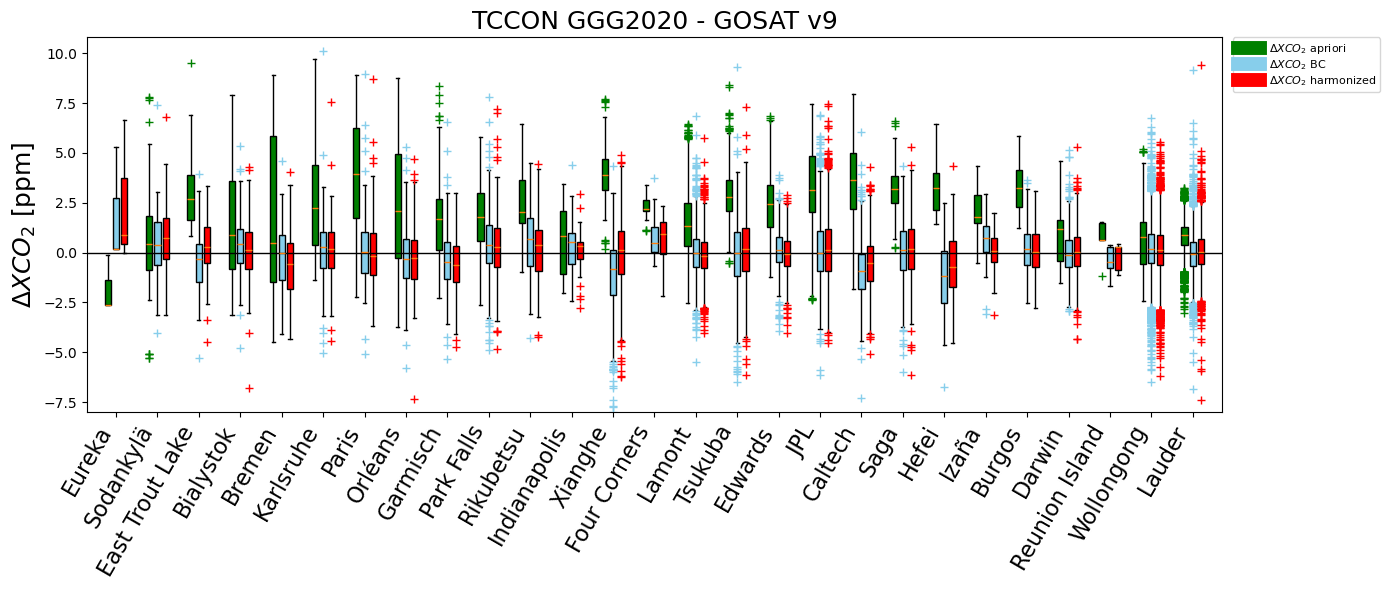

In [19]:
# Box and whisker plots - all TCCON sites 

positions = []
pos = 0
width = 0.2  # spacing between grouped boxes

categories = ['gosat_xco2_apriori','gosat_xco2','gosat_xco2_harmonized']
colors = {'gosat_xco2_apriori':'green', 'gosat_xco2':'skyblue', 'gosat_xco2_harmonized':'red'}


# landH
fig, ax = plt.subplots(figsize=(14,6))

# get TCCON sites and their lats
sites = tccon_gosat_collocations['tccon_site'].unique()
site_lats = [tccon_gosat_collocations[tccon_gosat_collocations['tccon_site'] == site].iloc[0].tccon_lat for site in sites]
s_l = list(zip(site_lats, sites))
# sort by lat in descending order
s_l_sorted = sorted(s_l)  
s_l_sorted.reverse()
sites = [sites for _, sites in s_l_sorted]
site_lats = [site_lats for site_lats, _ in s_l_sorted]


for site in sites:
    site_data = tccon_gosat_collocations[tccon_gosat_collocations['tccon_site'] == site]
    for i, cat in enumerate(categories):
        cat_data = site_data['tccon_xco2_ak_corrected_mean'] - site_data[cat]
        # Calculate position
        positions.append(pos + i*width - width)
        bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                        widths=0.15, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[cat])
        for flier in bp['fliers']:
            flier.set_markeredgecolor(colors[cat])
            flier.set_marker('+')
    pos += 1  # move to next site

# X-axis labels
ax.set_xticks(range(len(sites)))
ax.set_xticklabels(sites, rotation=60, ha='right', fontsize=16)

#ax.axhspan(-0.5, 0.5, color='gray', alpha=0.3)  # shaded target band
ax.axhline(0, color='k', linewidth=1)
ax.set_ylim(-8,10.8)

# Legend
for cat in categories:
    ax.plot([], c=colors[cat], label=cat, linewidth=10)
#ax.legend()
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)

# Modify the legend texts
legend_texts = legend.get_texts()
legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')

ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
ax.set_title('TCCON GGG2020 - GOSAT v9', fontsize=18)

plt.tight_layout()
plt.show()



In [154]:
# get min and max dates of GOSAT record
print(tccon_gosat_collocations['gosat_timestamp'].min())
print(tccon_gosat_collocations['gosat_timestamp'].max())

2009-04-23 11:56:57
2020-06-30 04:13:26


In [157]:
# create a YYYYM string for the full GOSAT record 
start_year, end_year = 2009, 2020
start_month, end_month = 1, 6

year = start_year
month = start_month
date_list = []
while year <= end_year:
    date_list += [str(year) + str(month)]
    month += 1
    if month == 13:
        year += 1
        month = 1
date_list_full = date_list[:-5]  # remove the 8/2020 - 12/2020
dates_list_to_keep = np.arange(0,len(date_list_full),6)  # only put tick marks every 6 months
date_list = np.array(date_list_full)[dates_list_to_keep]  # grab dates at every 6 months
dates_list_friendly = [str(date)[4:] + '/' + str(date)[2:4] for date in date_list]  # transform date_list into M/YY for plotting

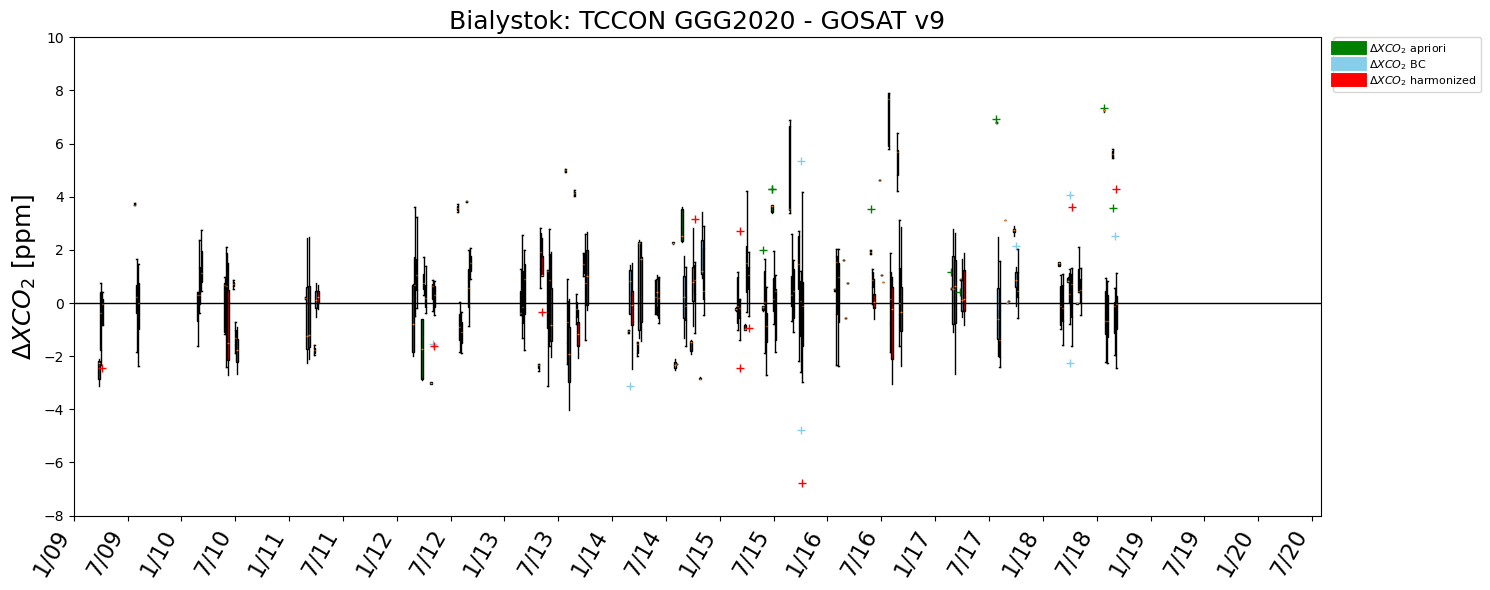

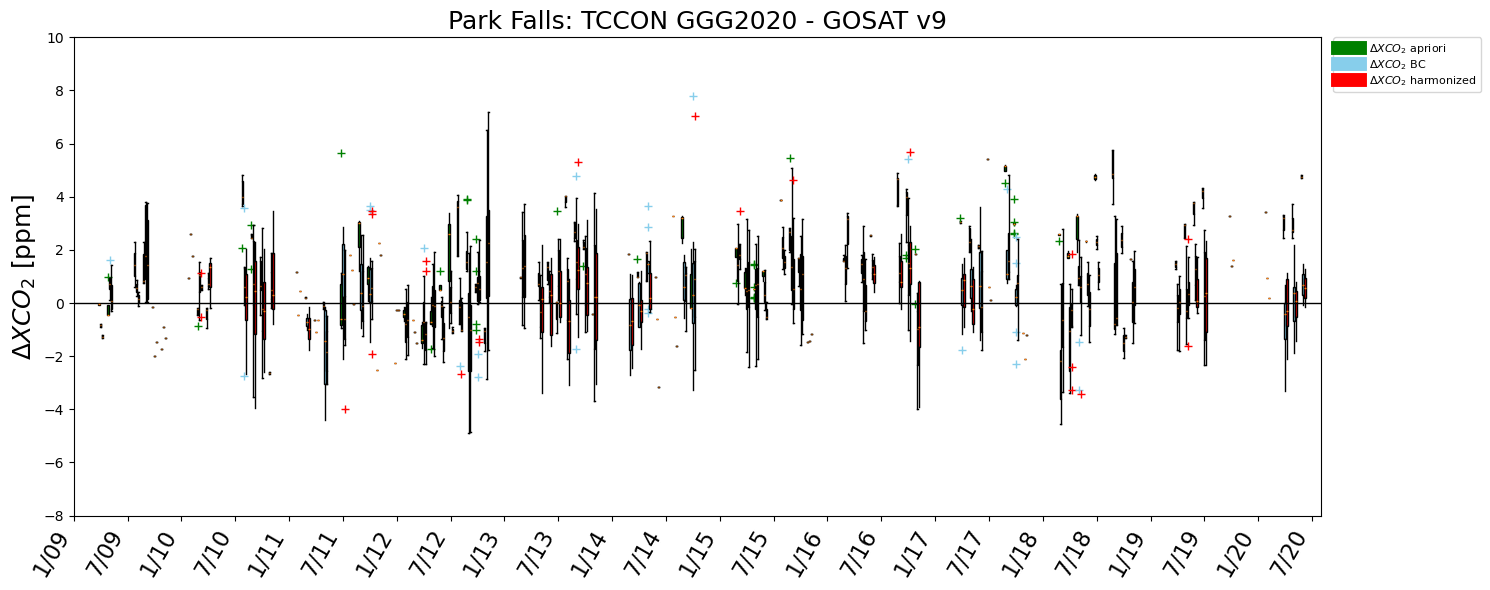

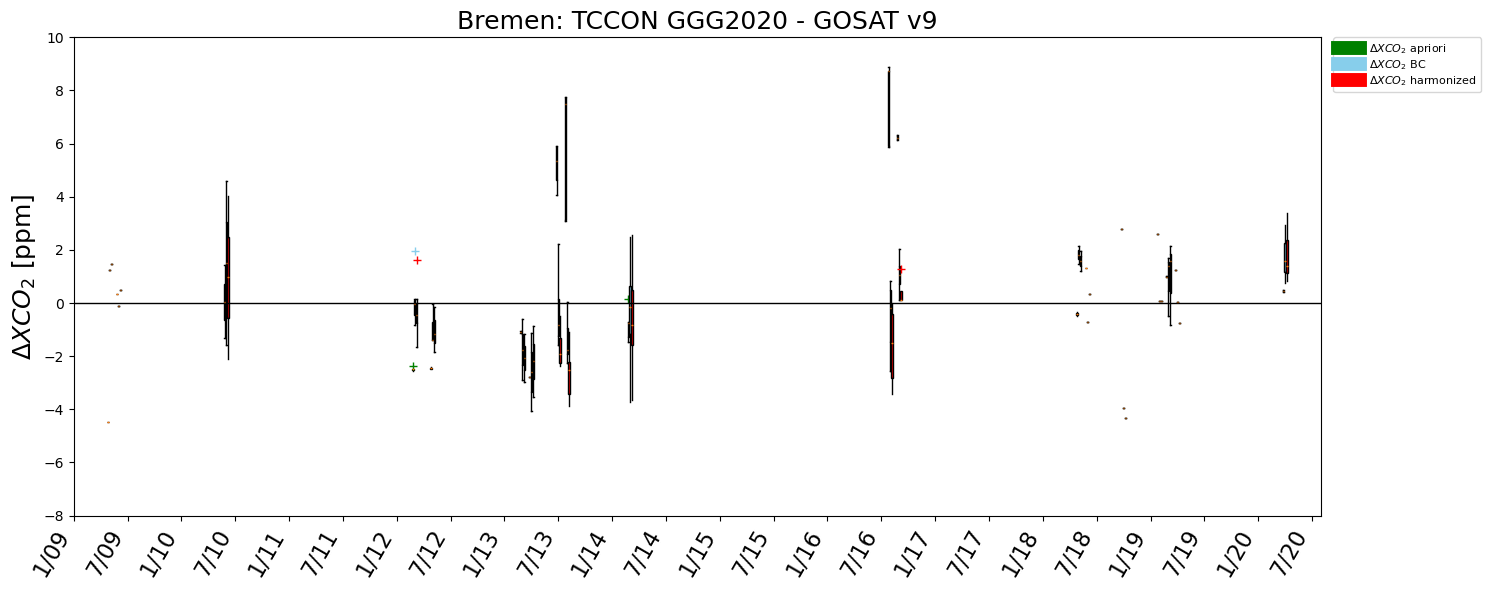

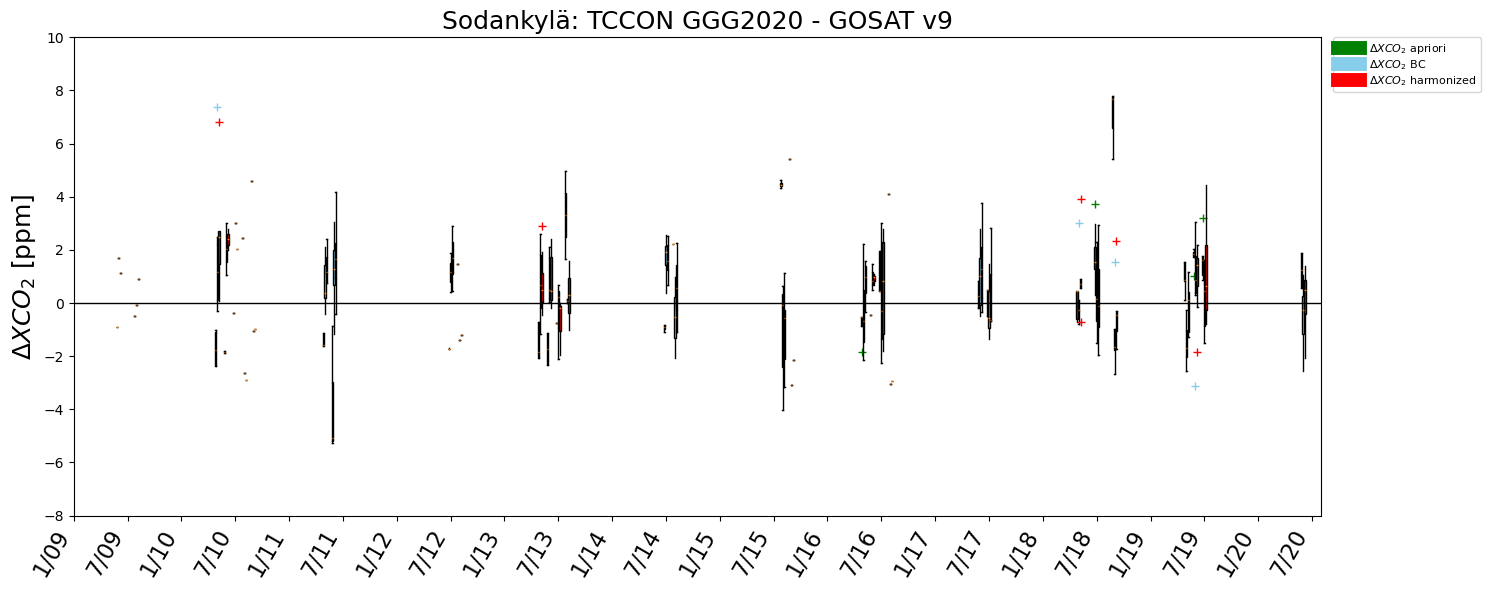

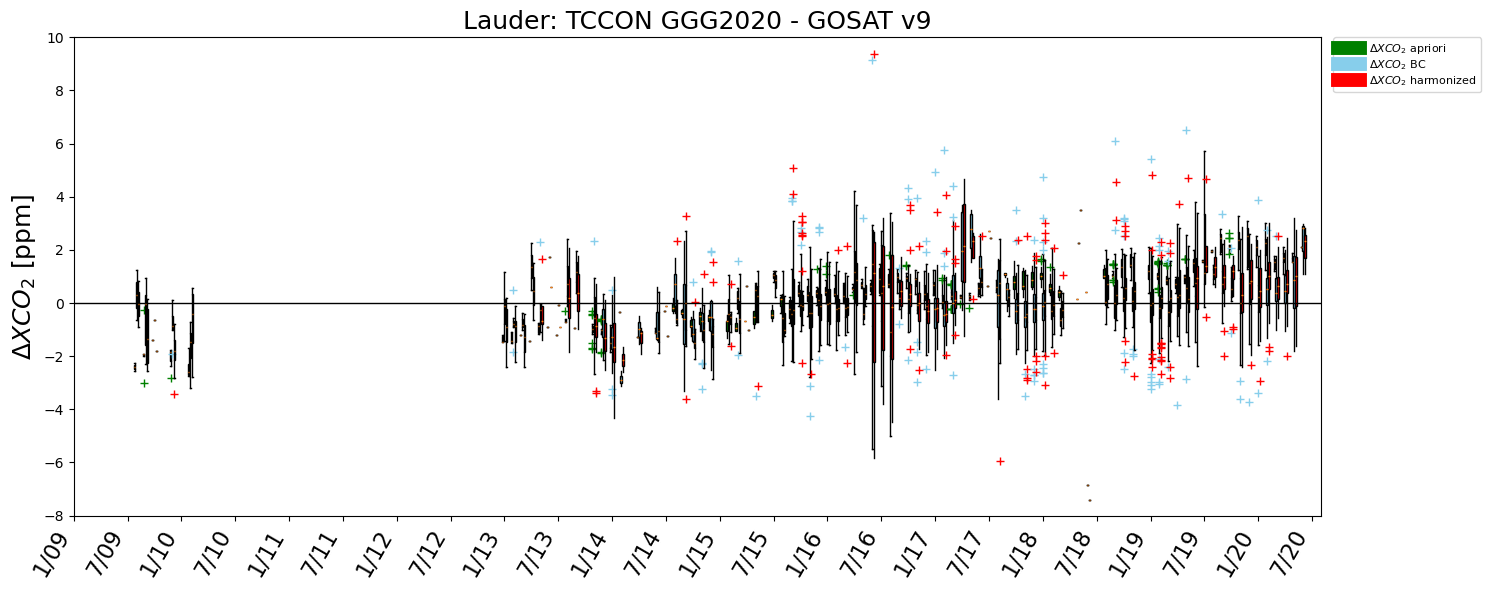

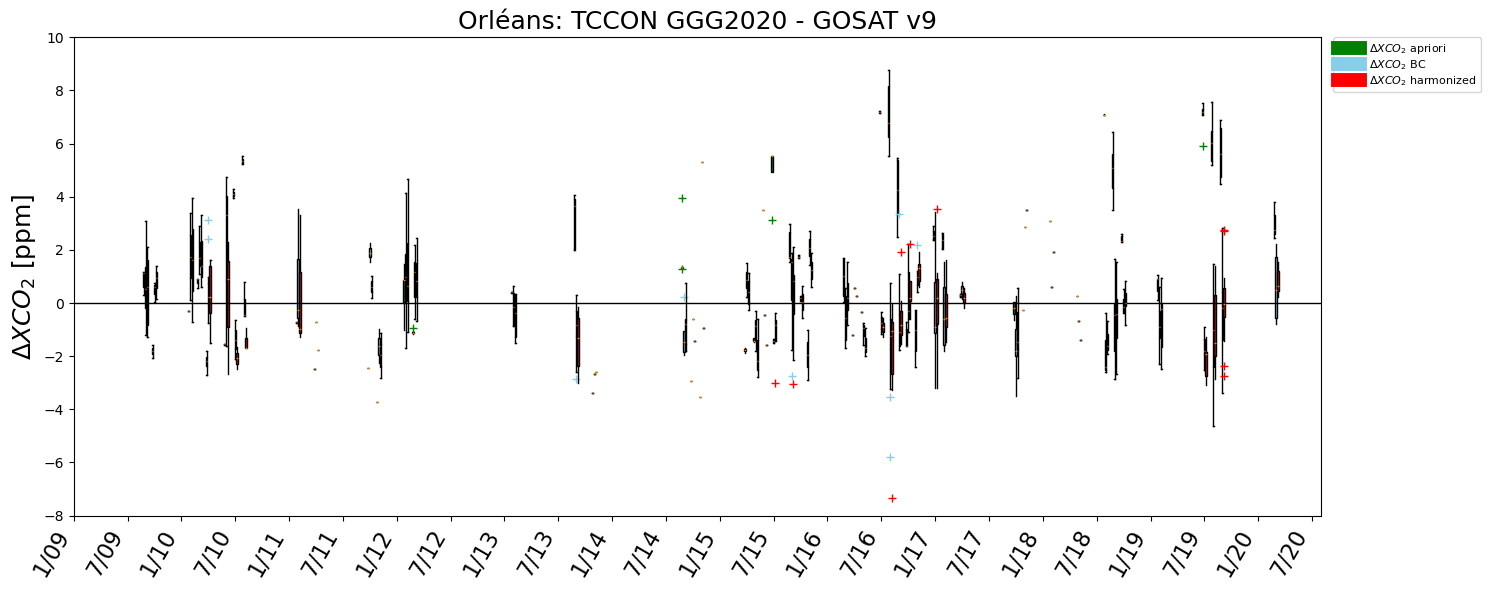

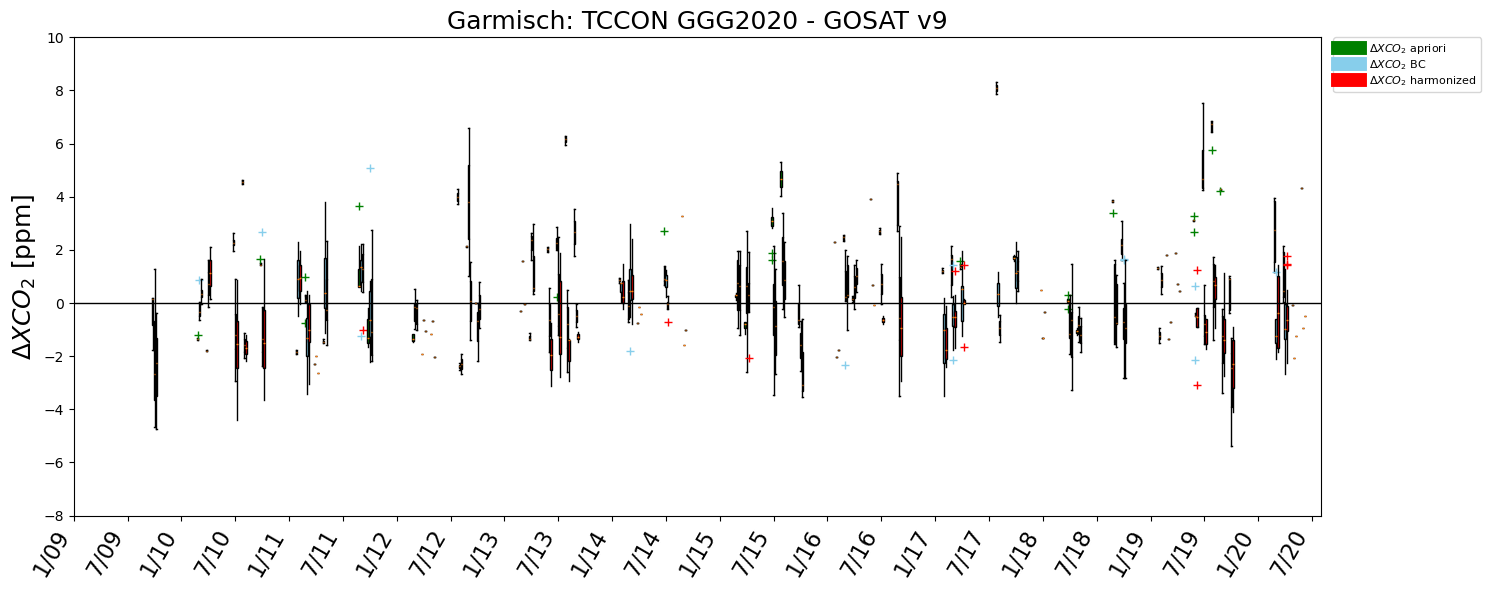

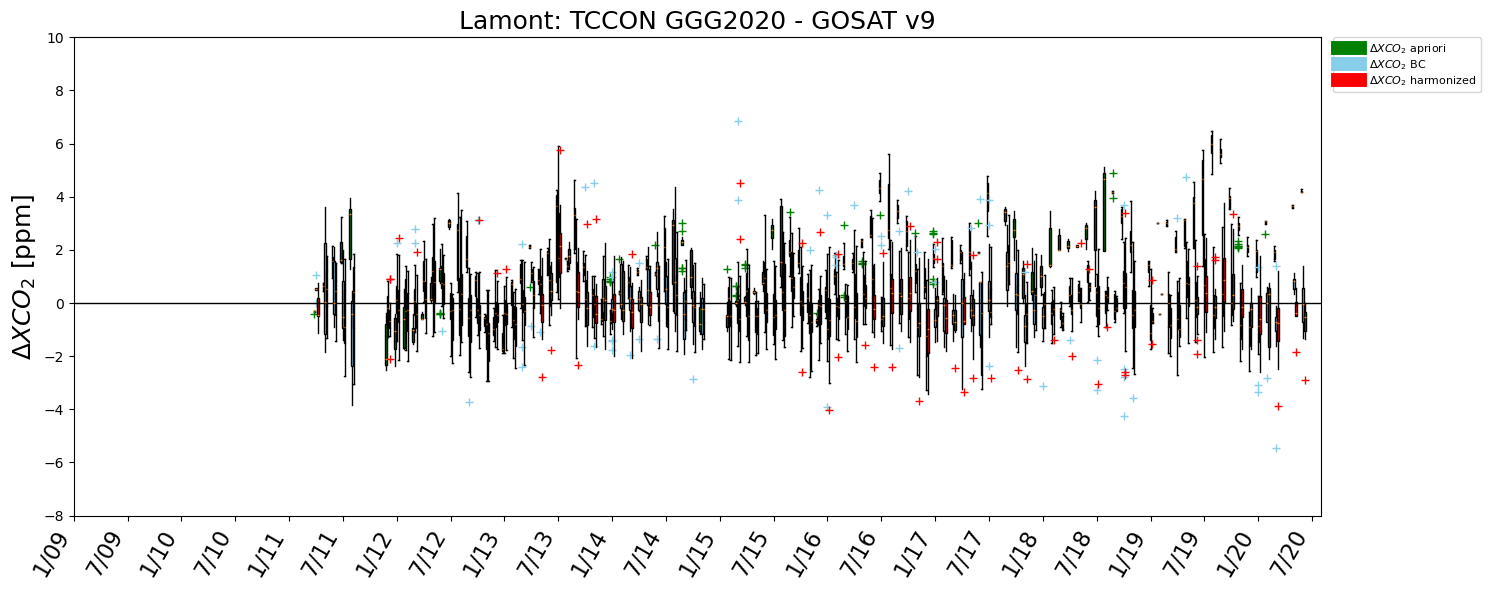

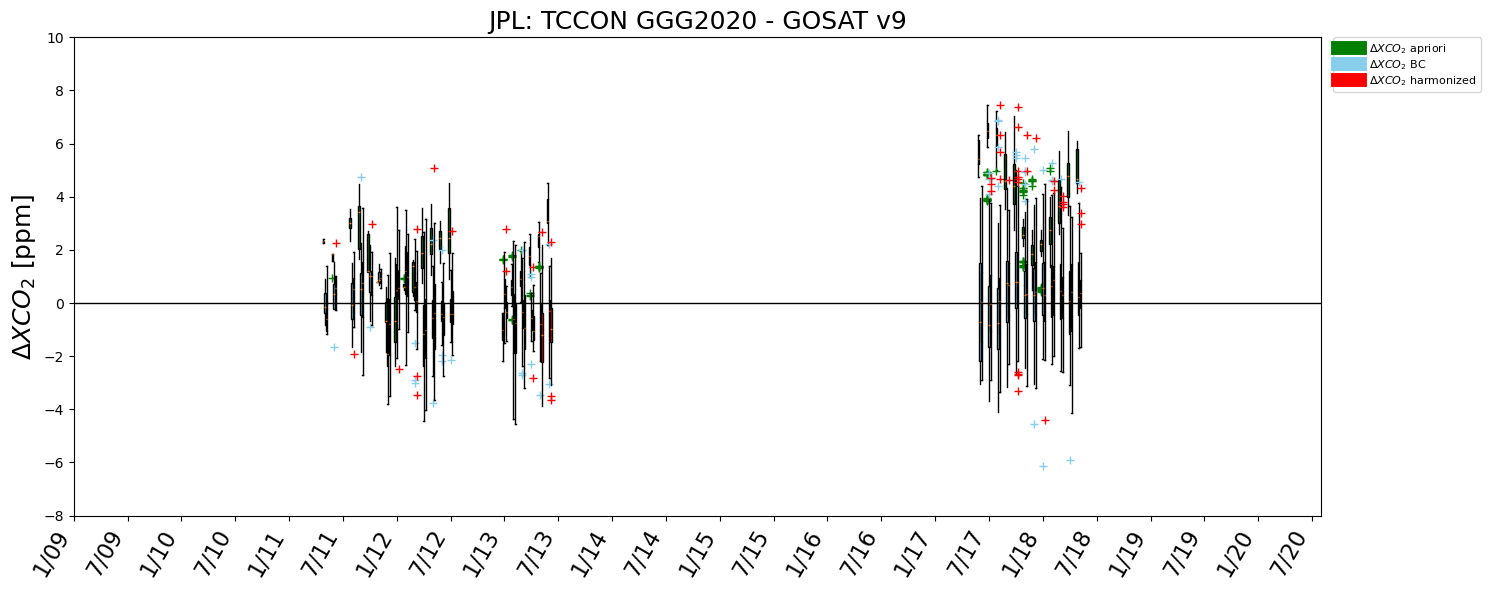

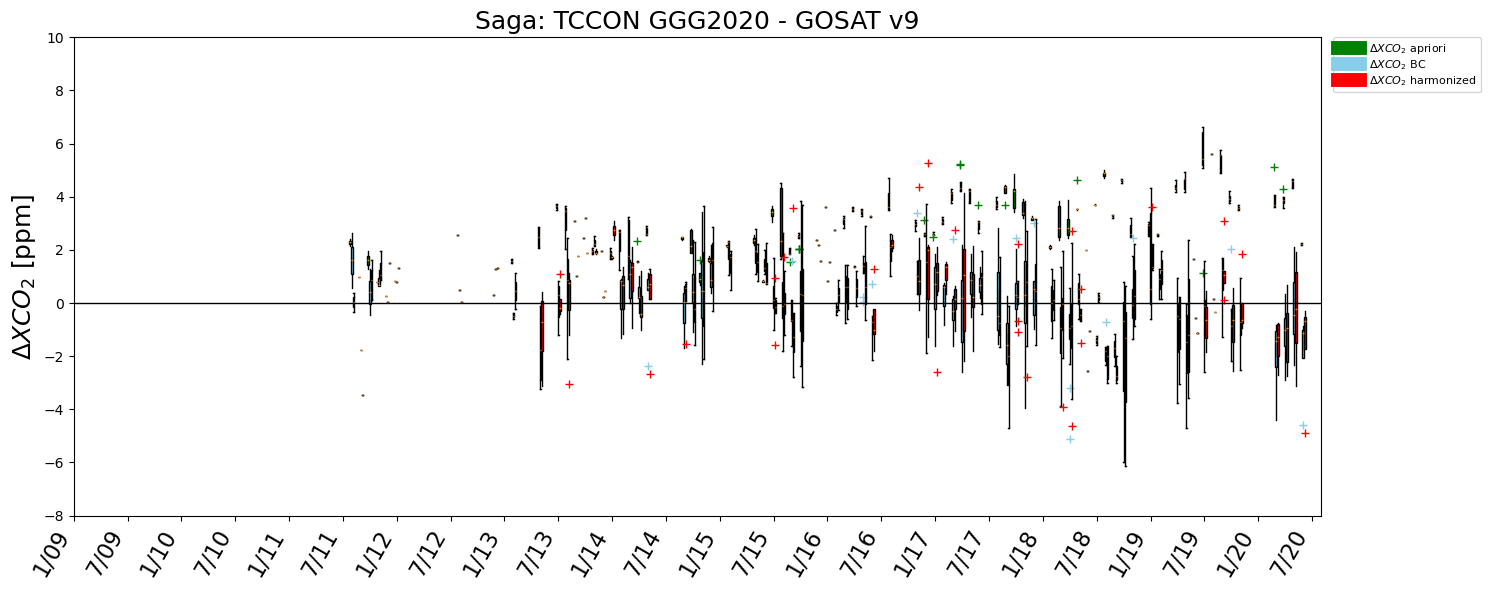

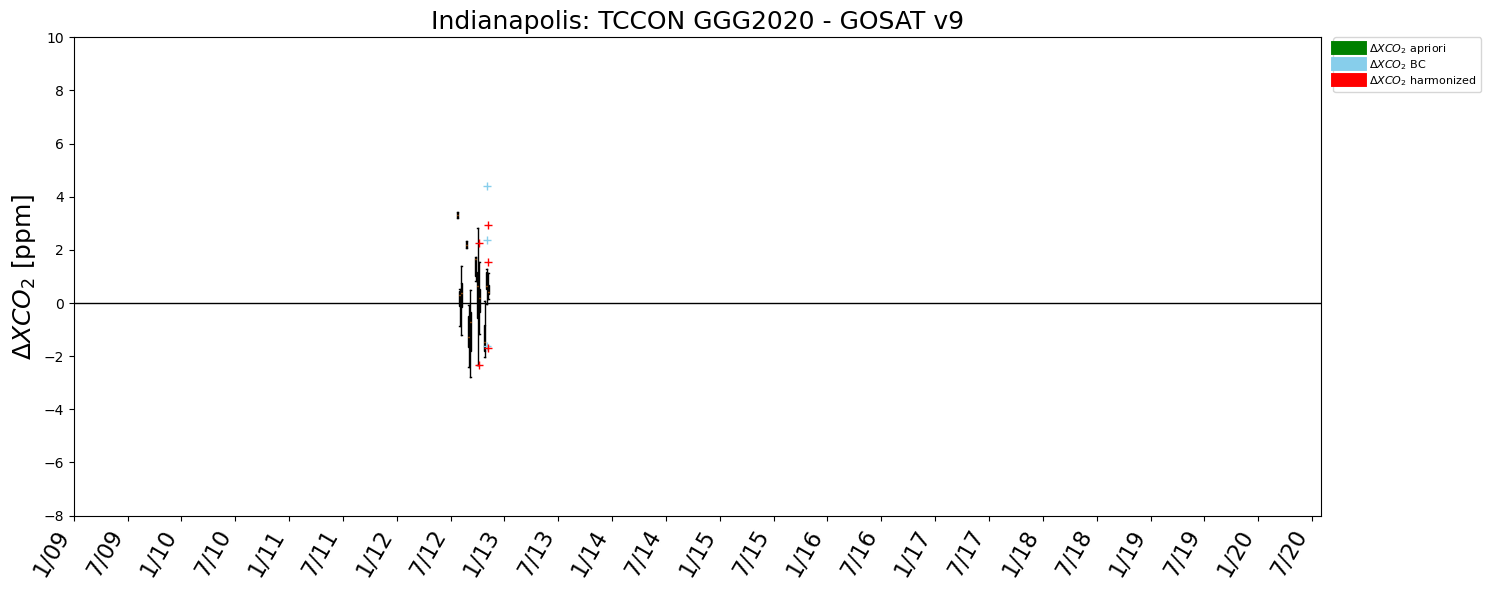

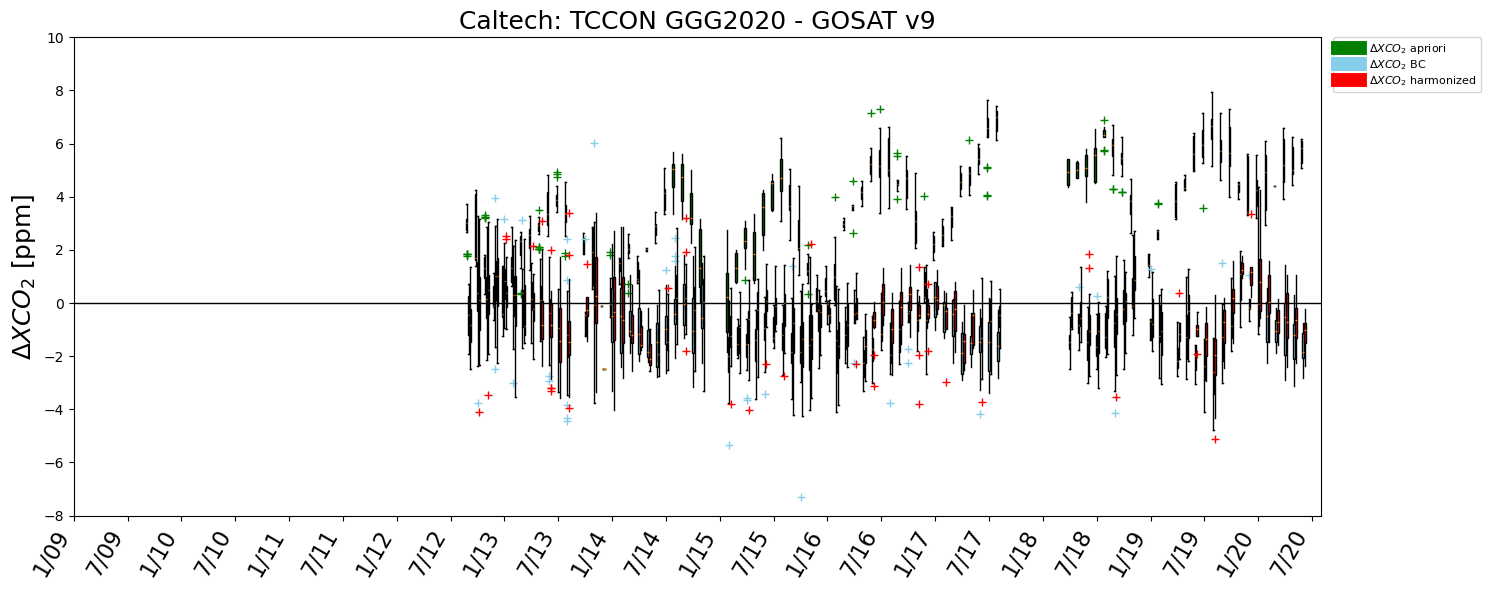

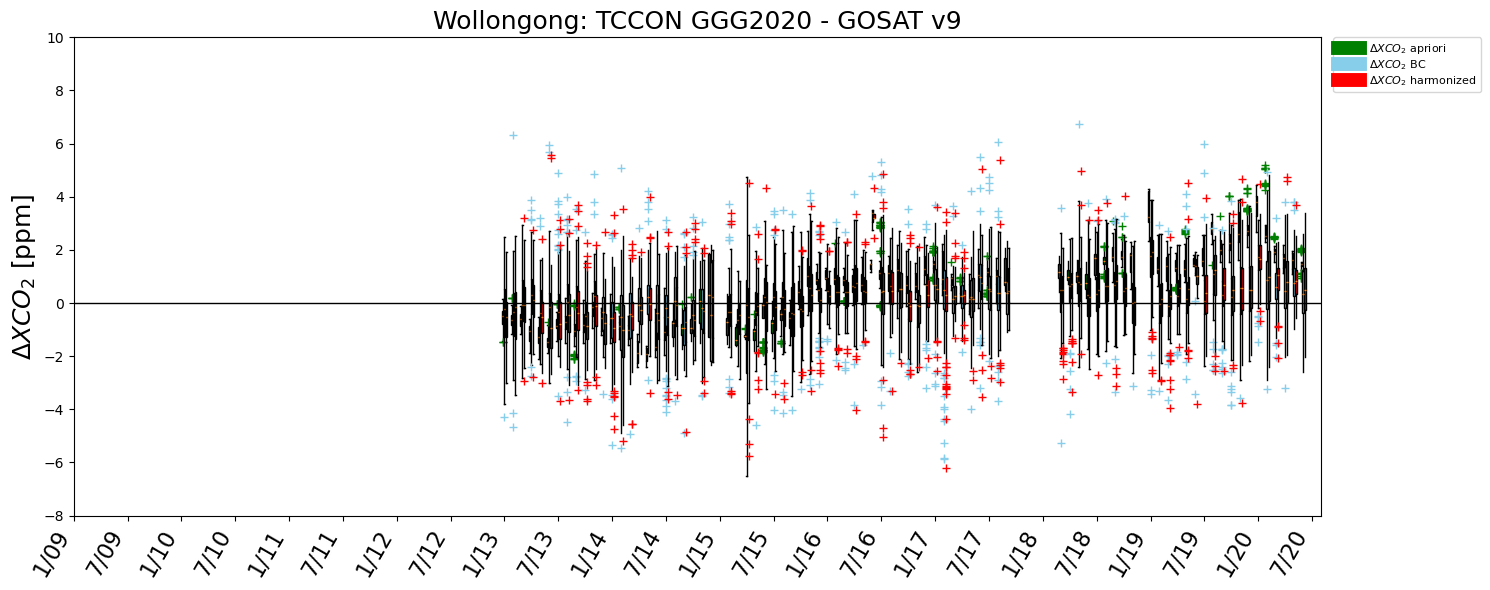

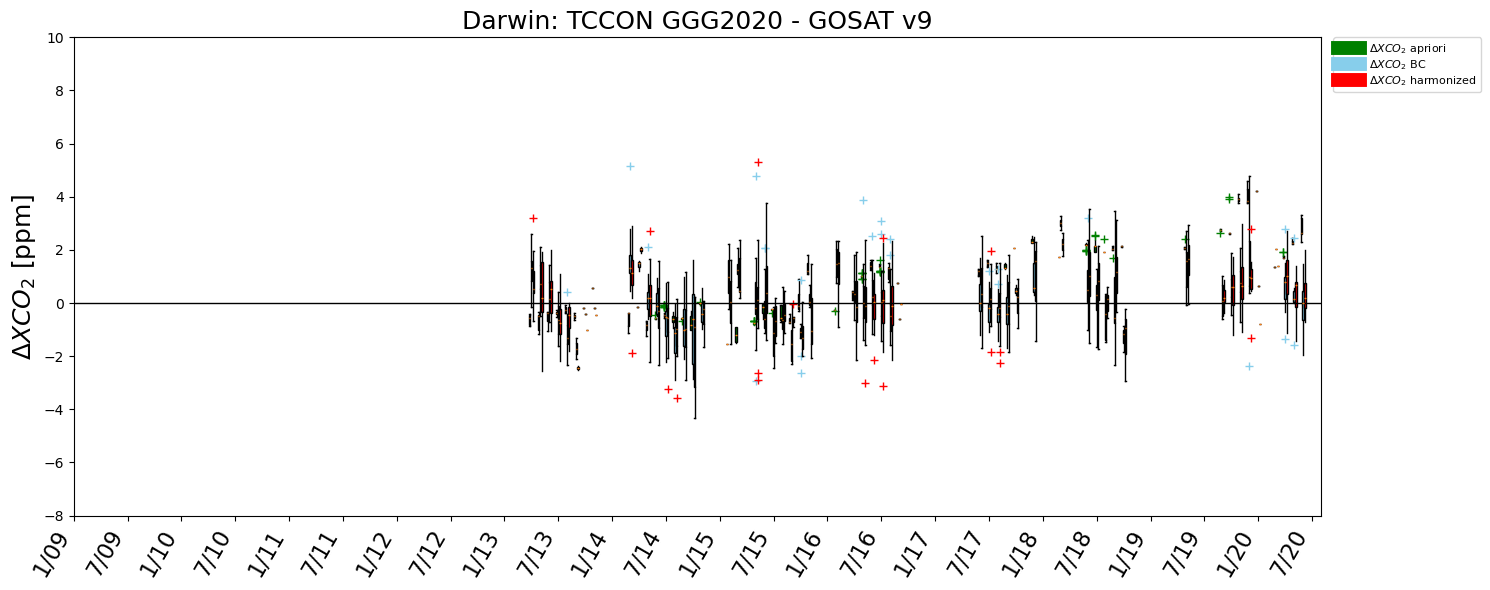

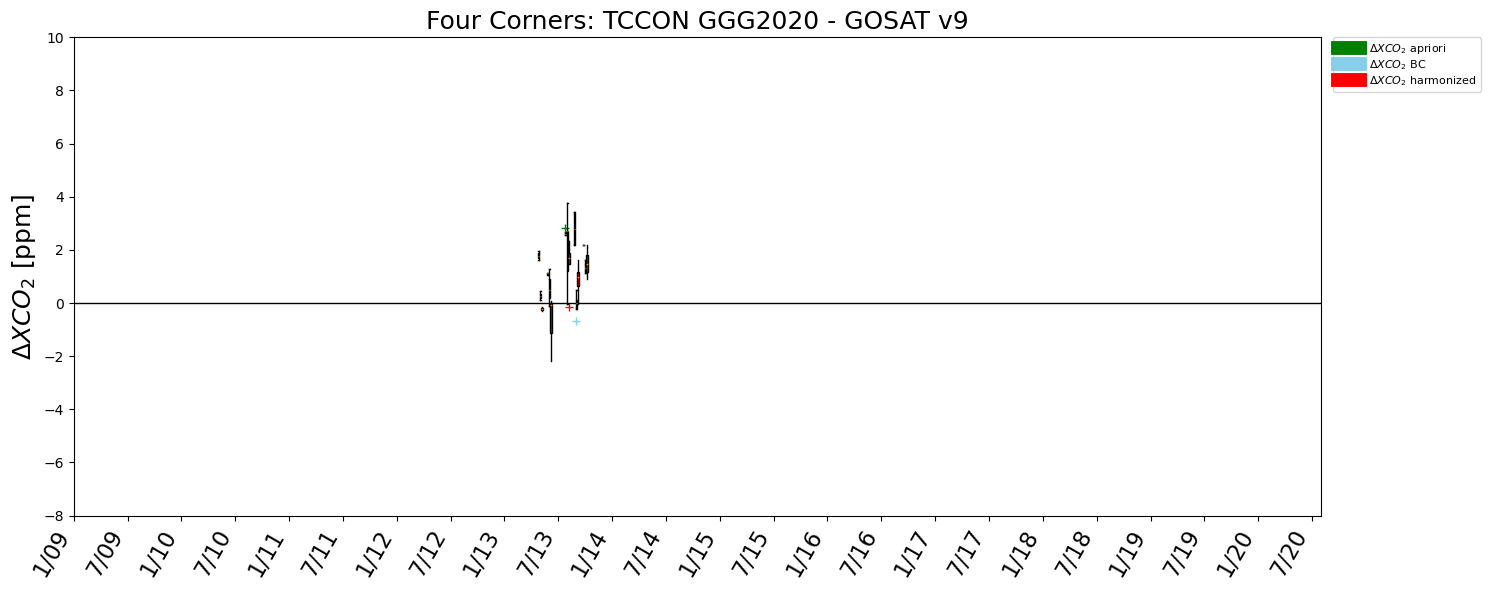

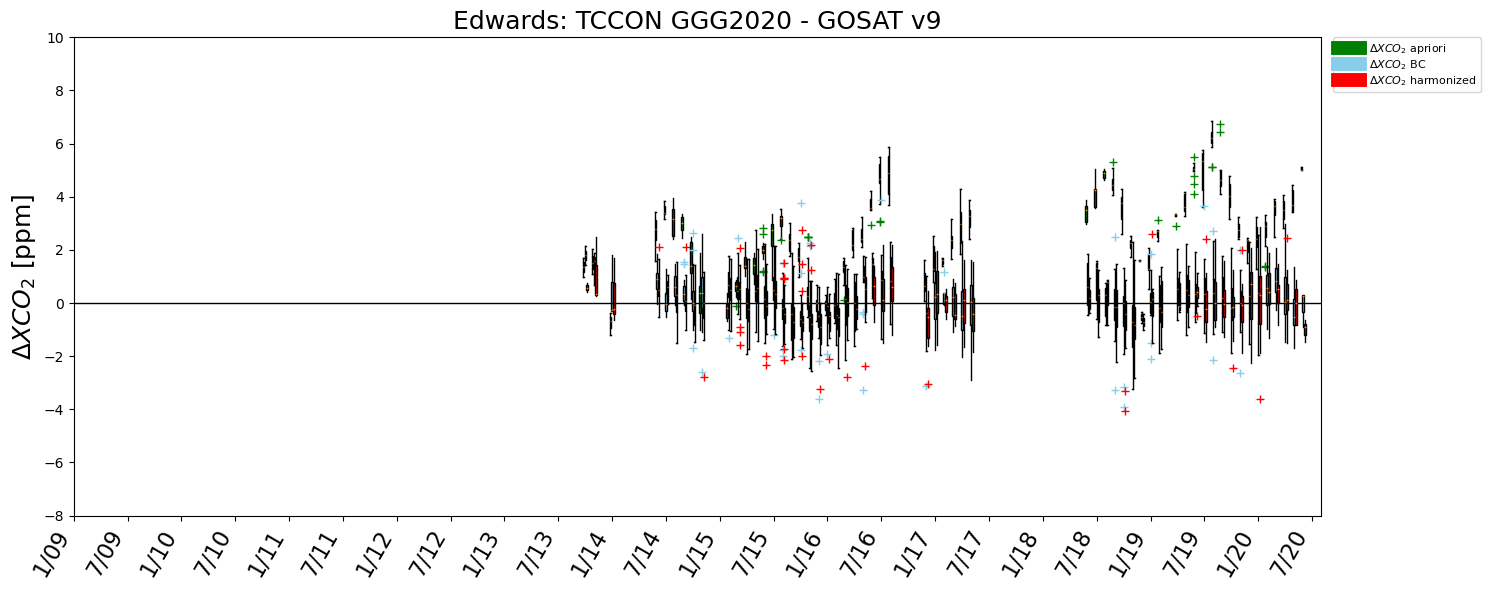

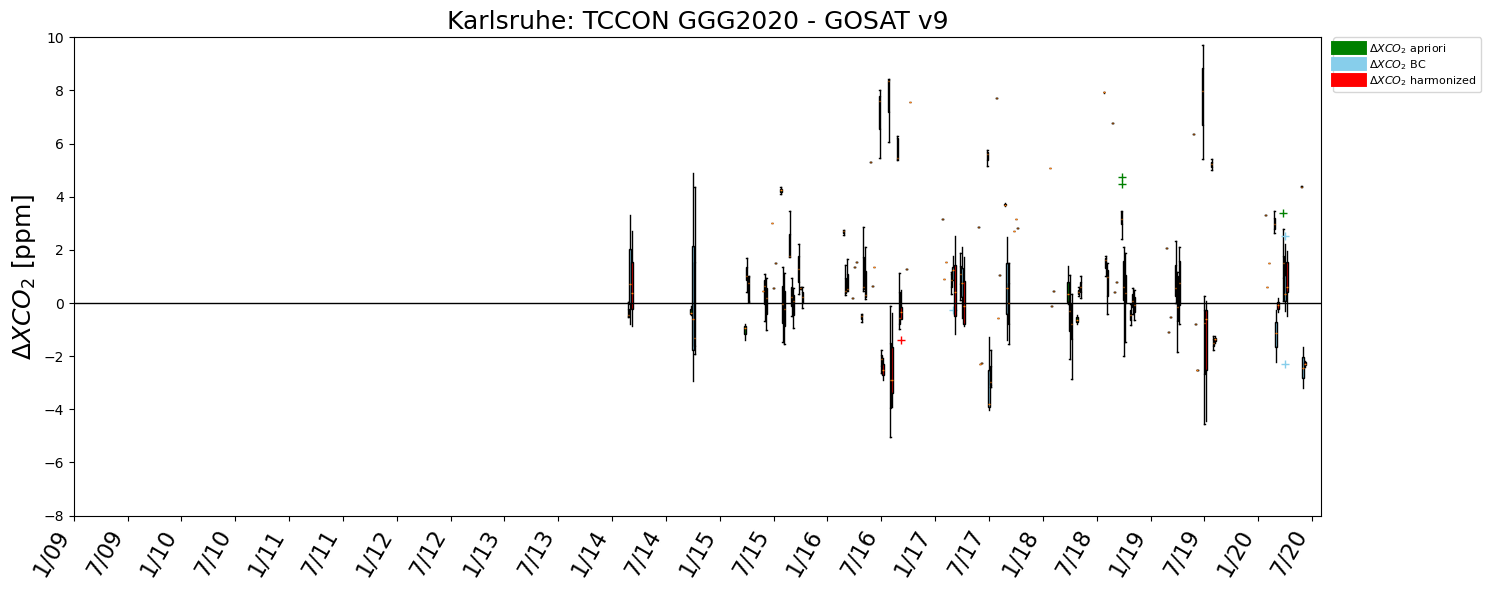

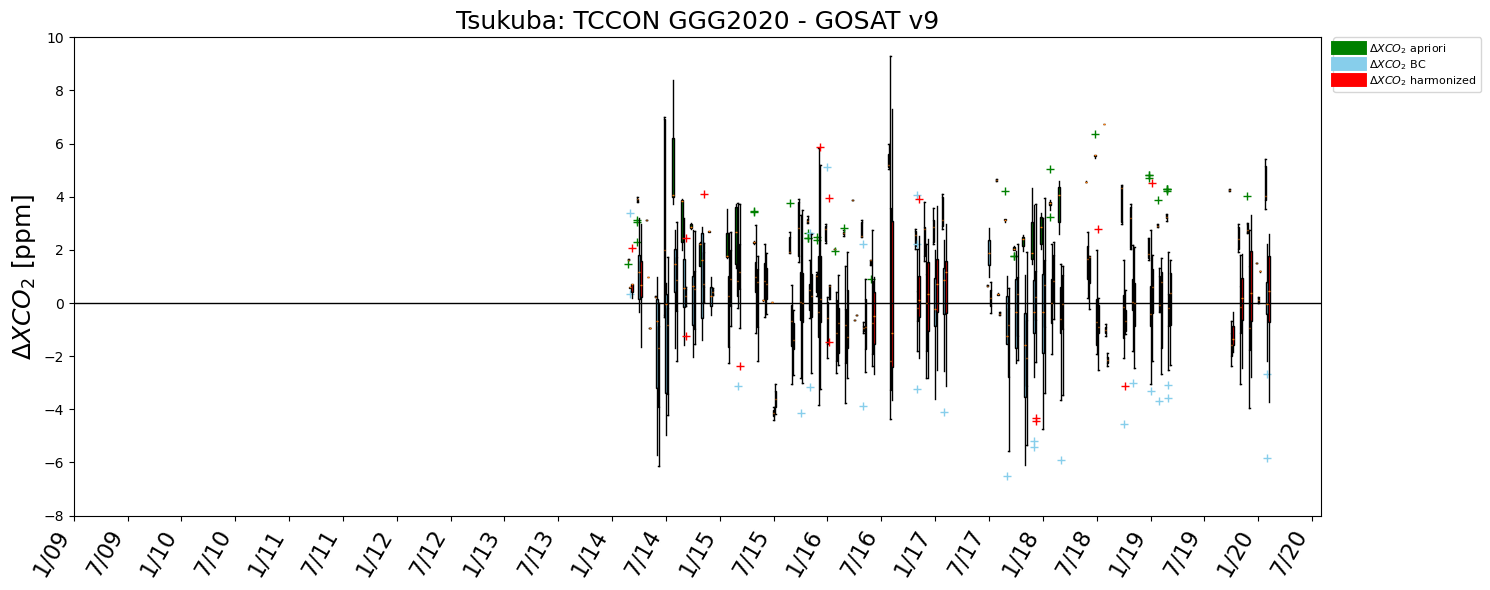

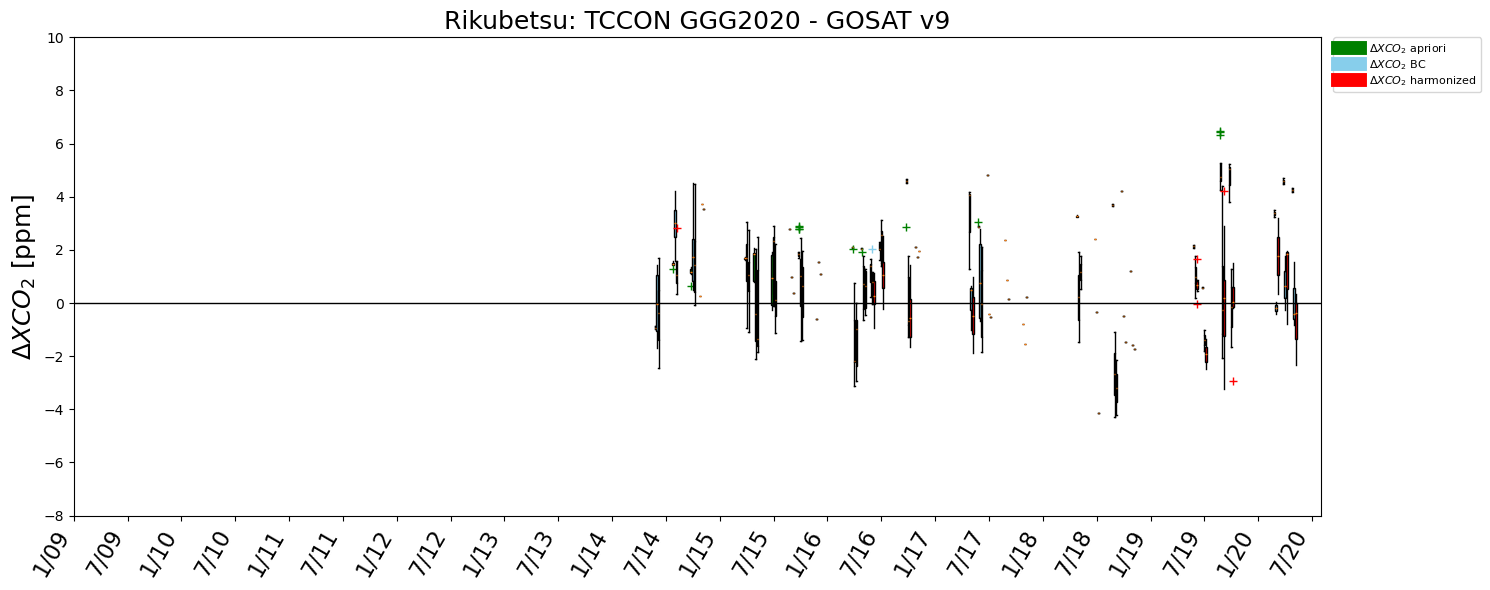

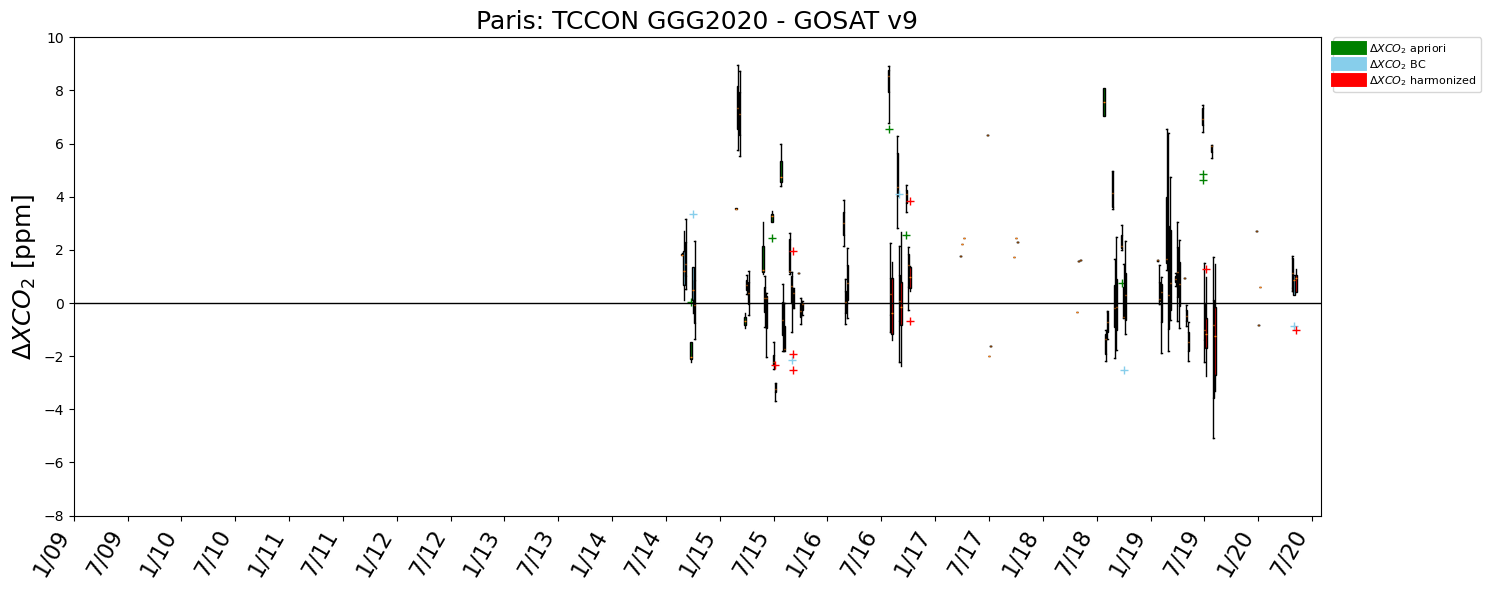

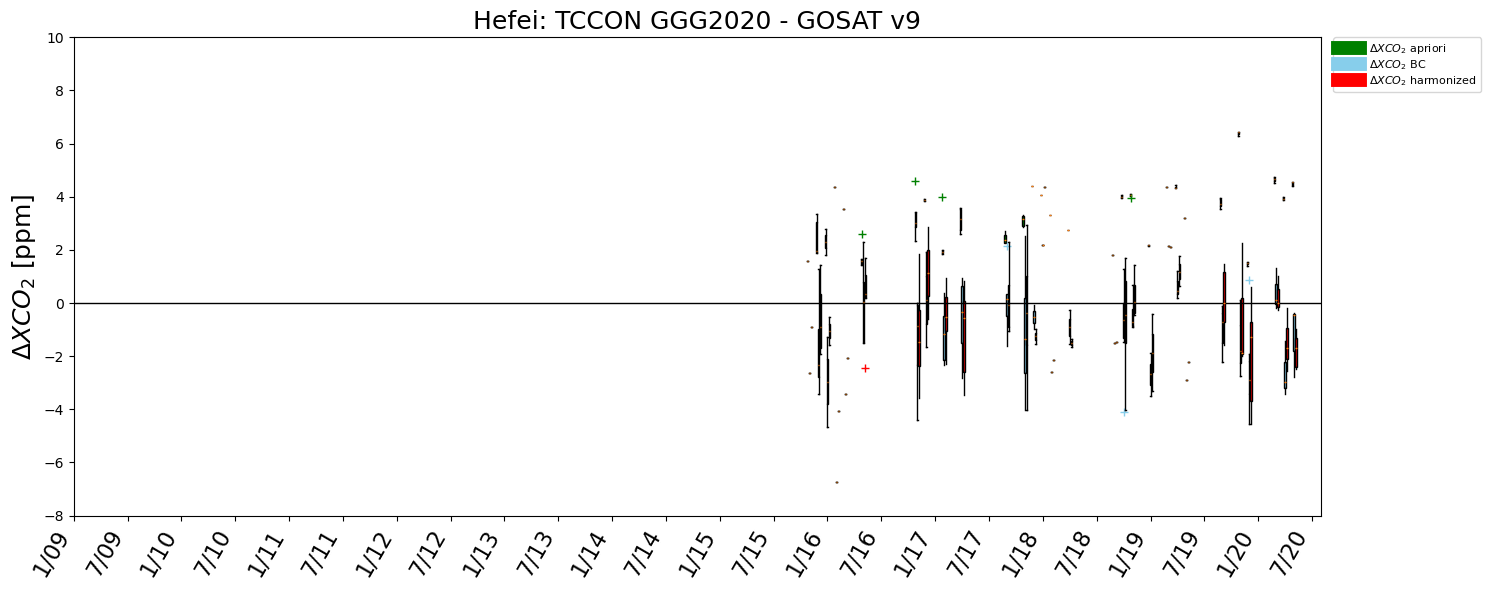

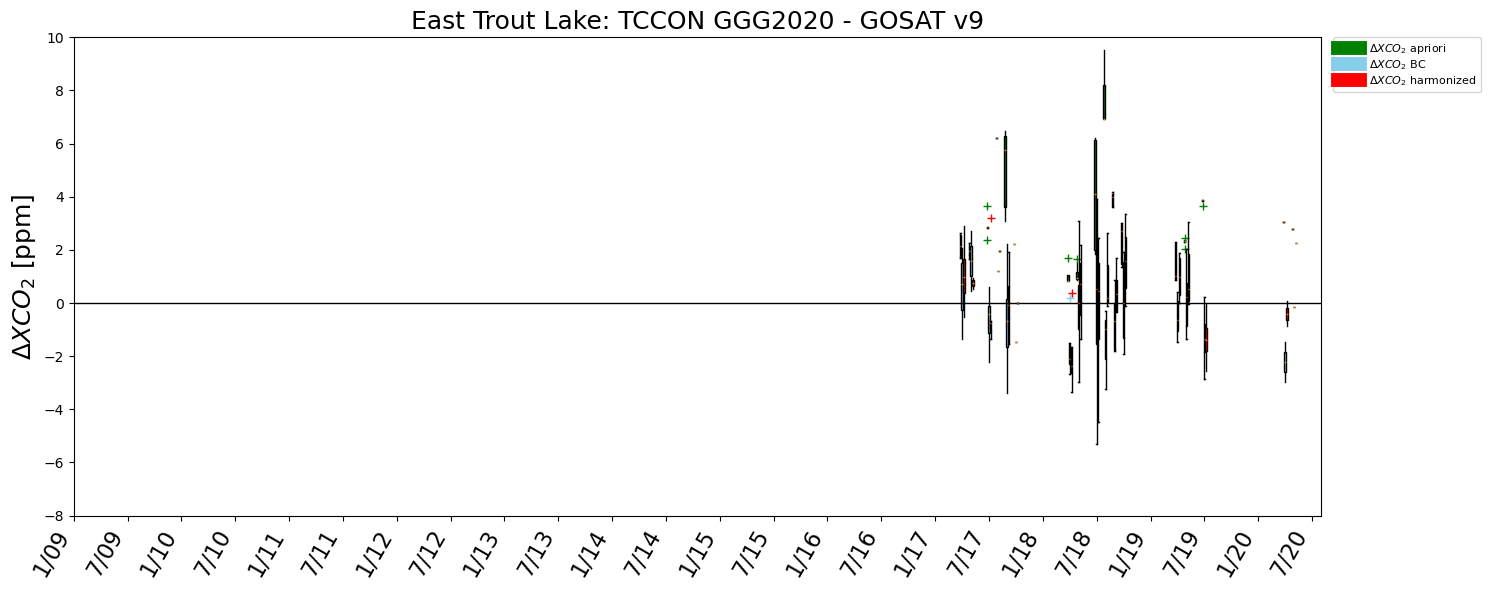

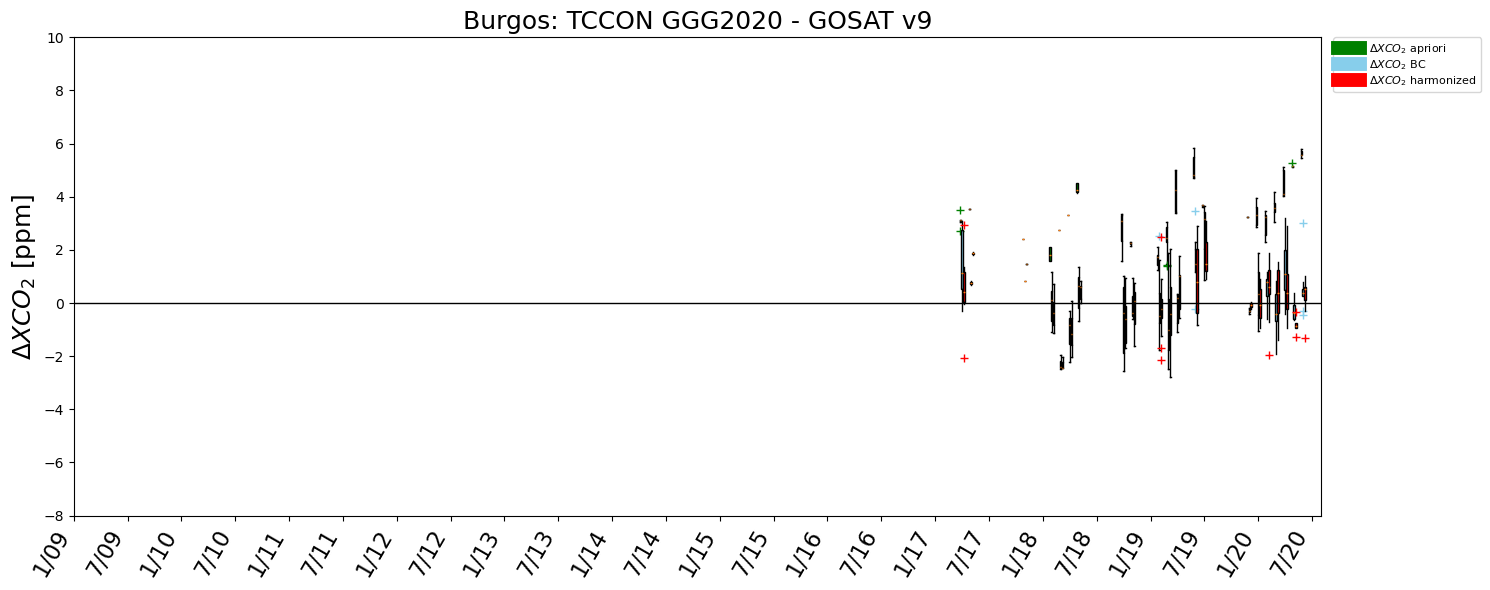

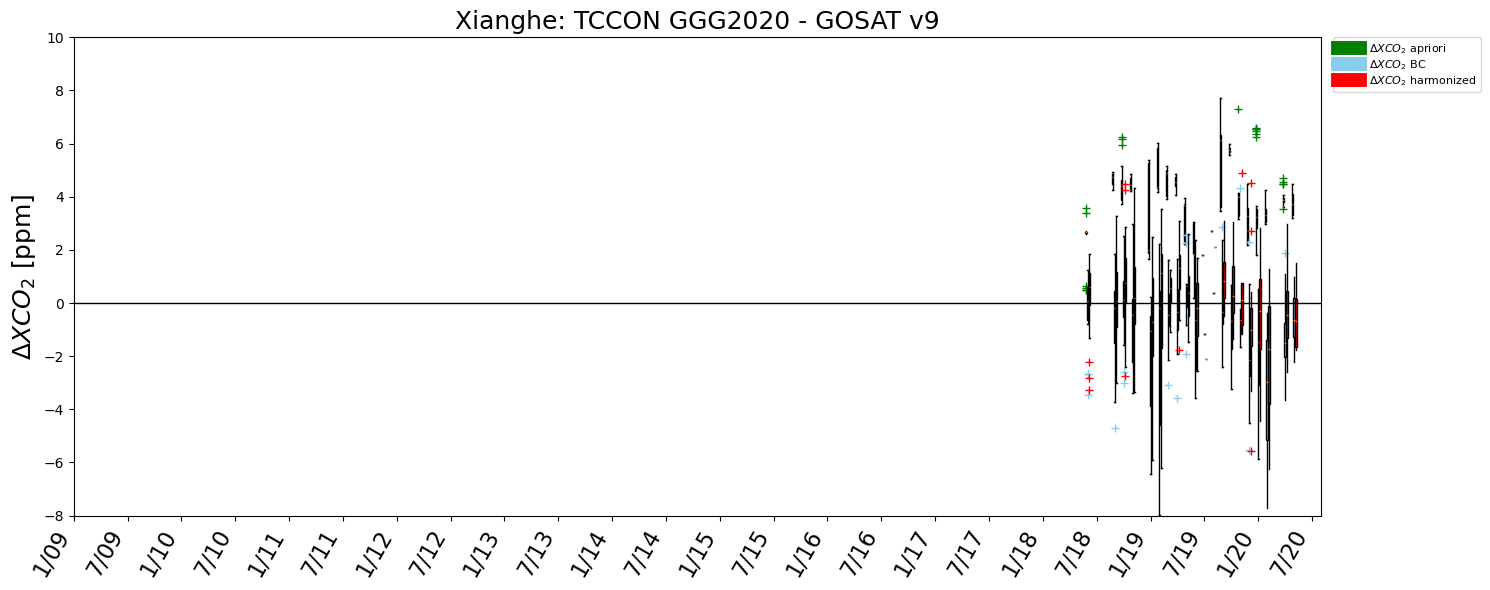

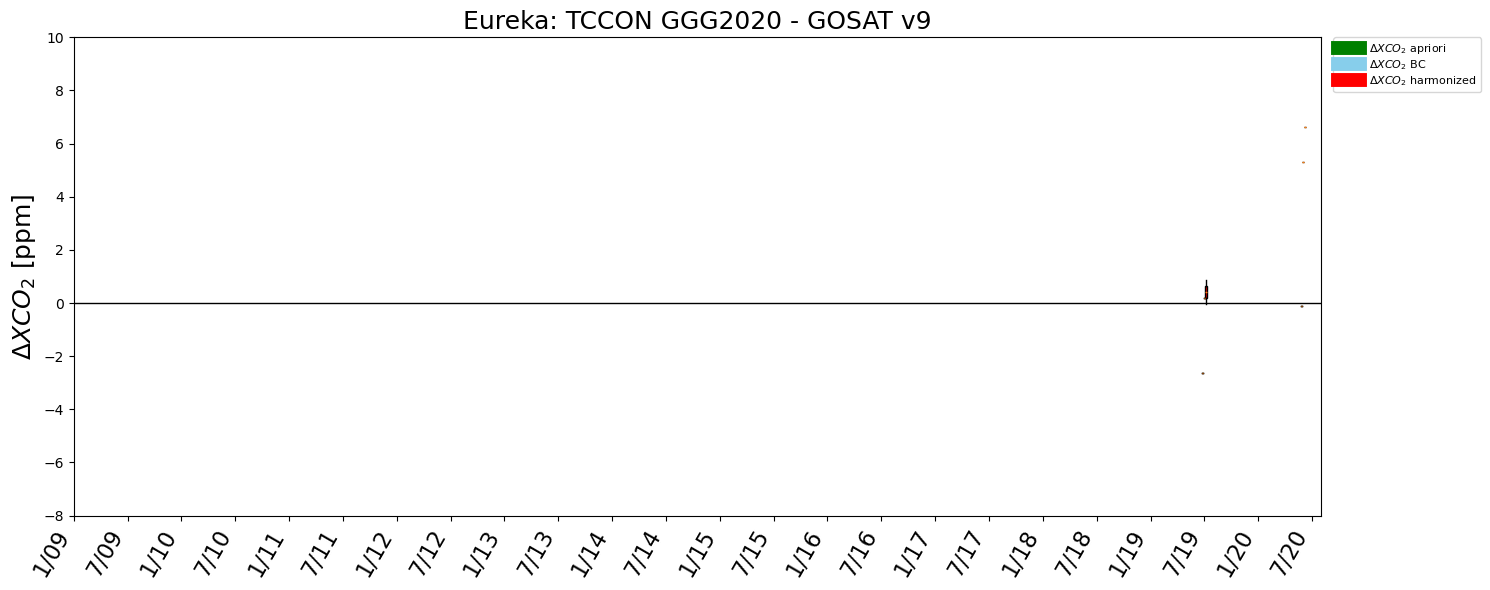

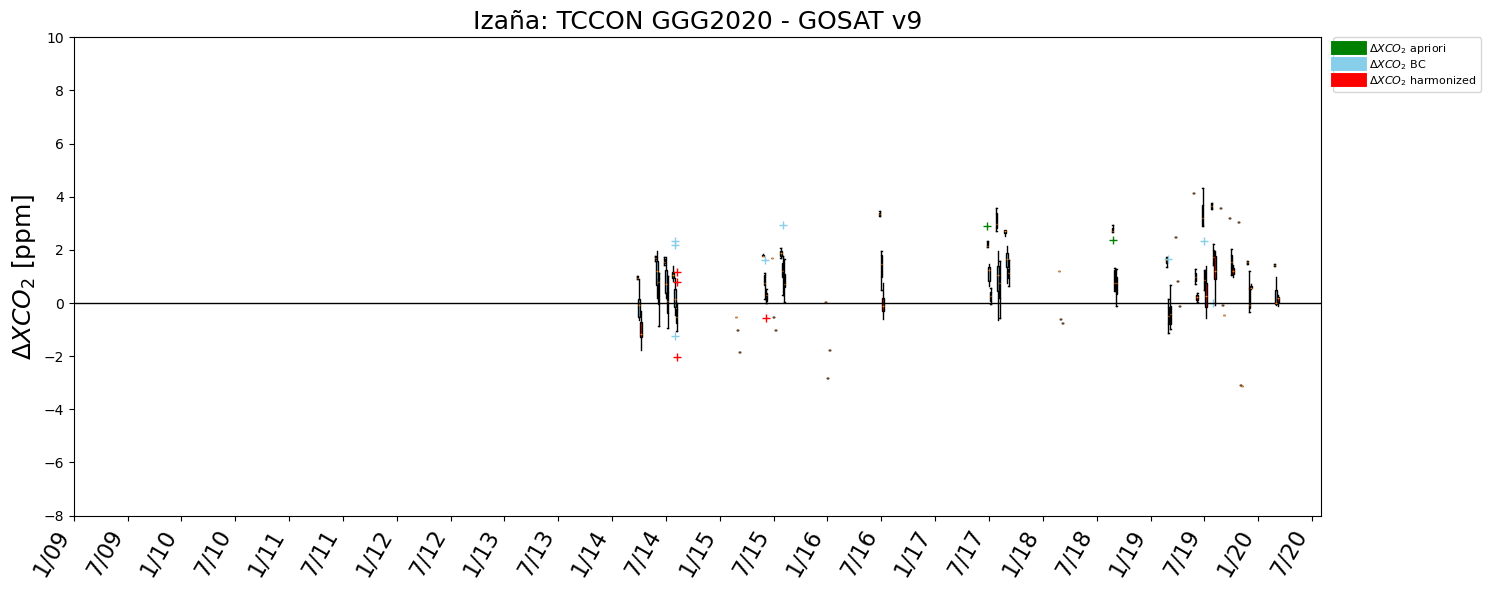

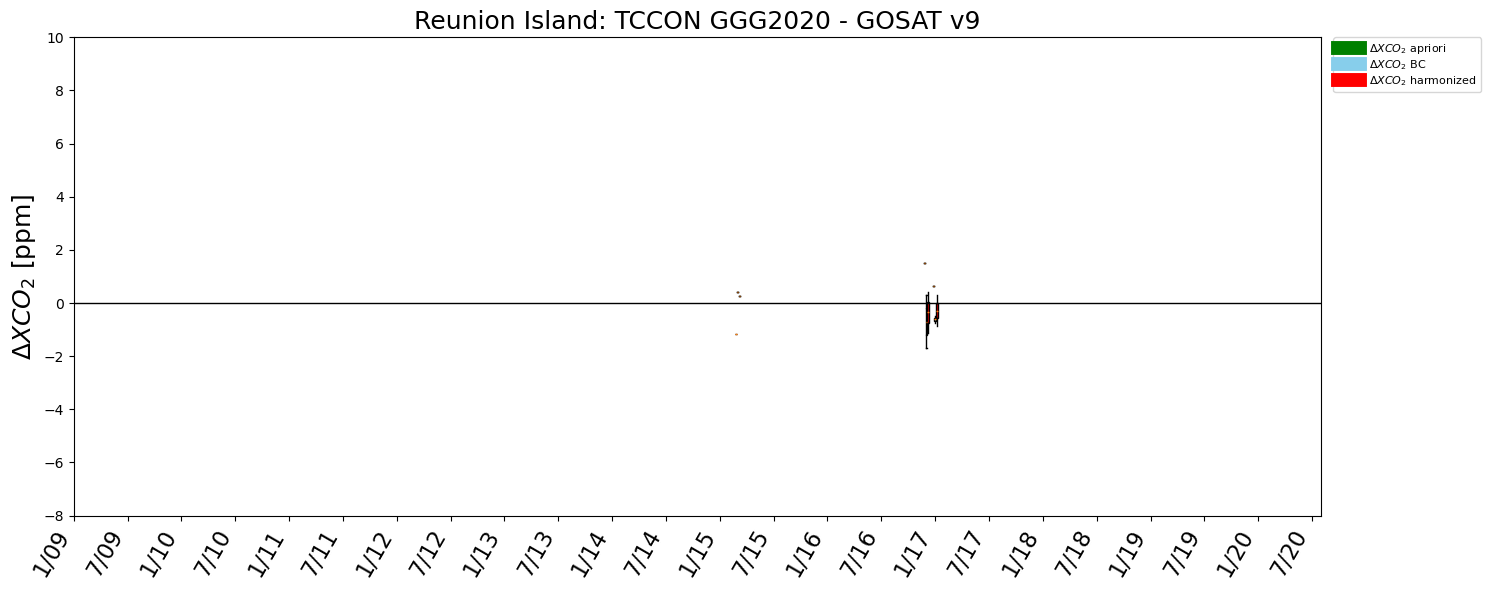

In [163]:
# Per site box & whisker plots

plot_dir = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\tccon_monthly\\'

tccon_gosat_collocations['year_month_str'] = tccon_gosat_collocations['gosat_year'].astype(str) + tccon_gosat_collocations['gosat_month'].astype(str)

categories = ['gosat_xco2_apriori','gosat_xco2','gosat_xco2_harmonized']
colors = {'gosat_xco2_apriori':'green', 'gosat_xco2':'skyblue', 'gosat_xco2_harmonized':'red'}

for site in tccon_gosat_collocations['tccon_site'].unique():
    site_data = tccon_gosat_collocations[tccon_gosat_collocations['tccon_site']==site]

    if site_data.shape[0] == 0:
        continue
    fig, ax = plt.subplots(figsize=(15,6))

    positions = []
    pos = -1
    width = 0.2  # spacing between grouped boxes

    dates_with_data = []  # use this for xticklabels
    for year_month in date_list_full: # iterate over every month in the GOSAT record  
        year_month_data = site_data[site_data['year_month_str'] == year_month]
        pos += 1 # position for where to plot b&w
        if year_month_data.shape[0] == 0:
            continue
        dates_with_data += [year_month]
        #print(f'{year_month_data['gosat_year'].unique()} - {year_month_data['gosat_month'].unique()}')
        for i, cat in enumerate(categories):
            cat_data = year_month_data['tccon_xco2_ak_corrected_mean'] - year_month_data[cat]
            # Calculate position
            positions.append(pos + i*width - width)
            bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                            widths=0.15, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor(colors[cat])
            for flier in bp['fliers']:
                flier.set_markeredgecolor(colors[cat])
                flier.set_marker('+')
    # X-axis labels
    ax.set_xticks(dates_list_to_keep)
    ax.set_xticklabels(dates_list_friendly, rotation=60, ha='right', fontsize=16)  
    ax.set_xlim(0,len(x_labels_dict)+1)   
        
    ax.axhline(0, color='k', linewidth=1)
    ax.set_ylim(-8,10)
    
    # Legend
    for cat in categories:
        ax.plot([], c=colors[cat], label=cat, linewidth=10)
    #ax.legend()
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)
    
    # Modify the legend texts
    legend_texts = legend.get_texts()
    legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
    legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
    legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')
    
    ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
    ax.set_title(f'{site}: TCCON GGG2020 - GOSAT v9', fontsize=18)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{site}_montly_tccon_to_gosat.png'), bbox_inches='tight')
    plt.show()

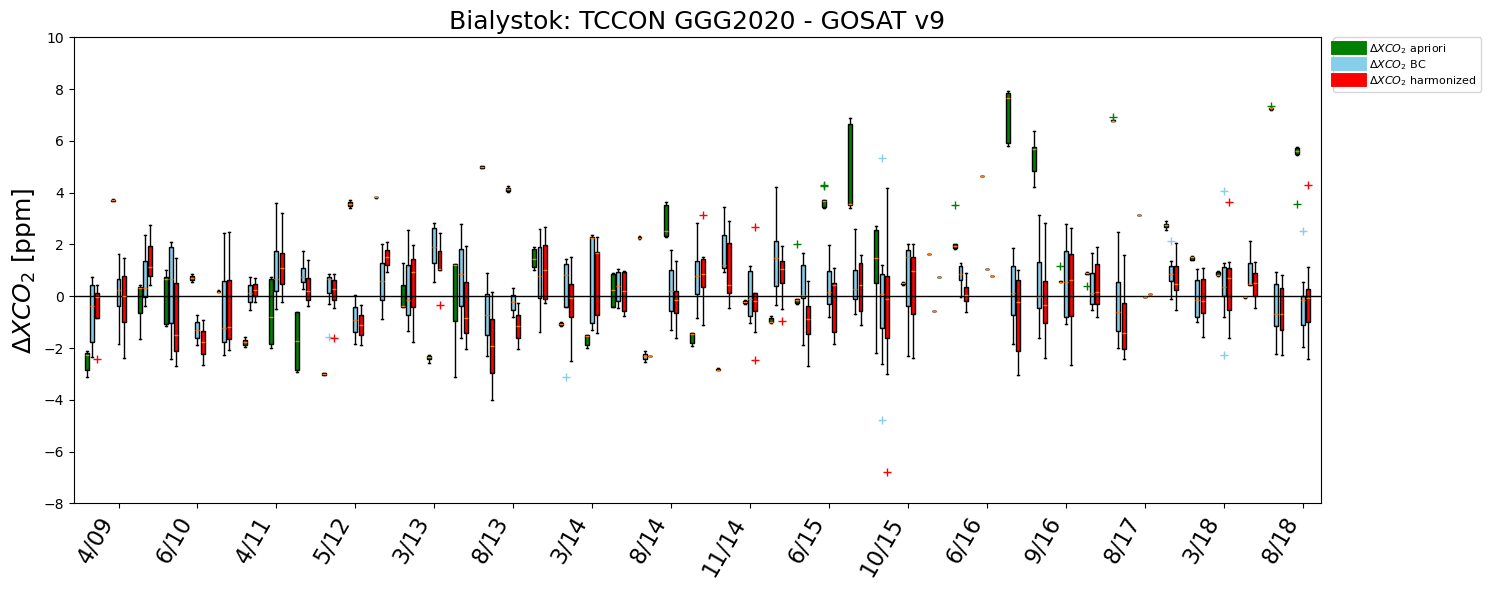

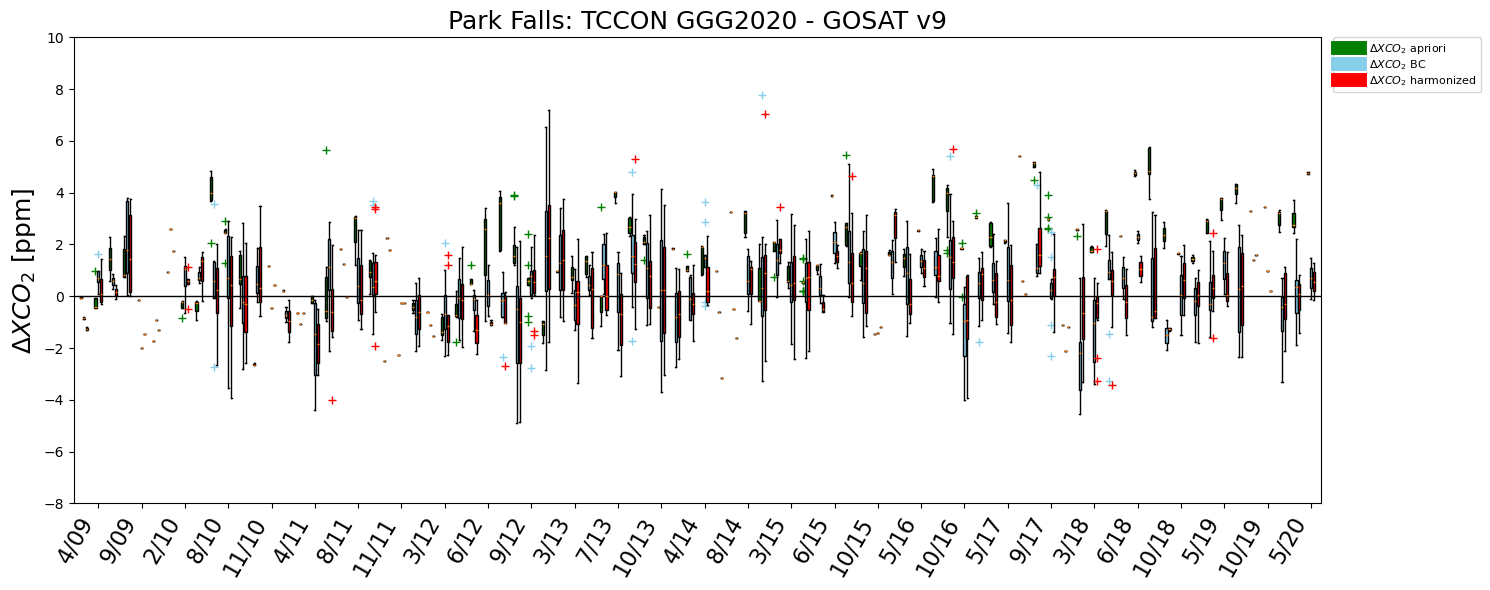

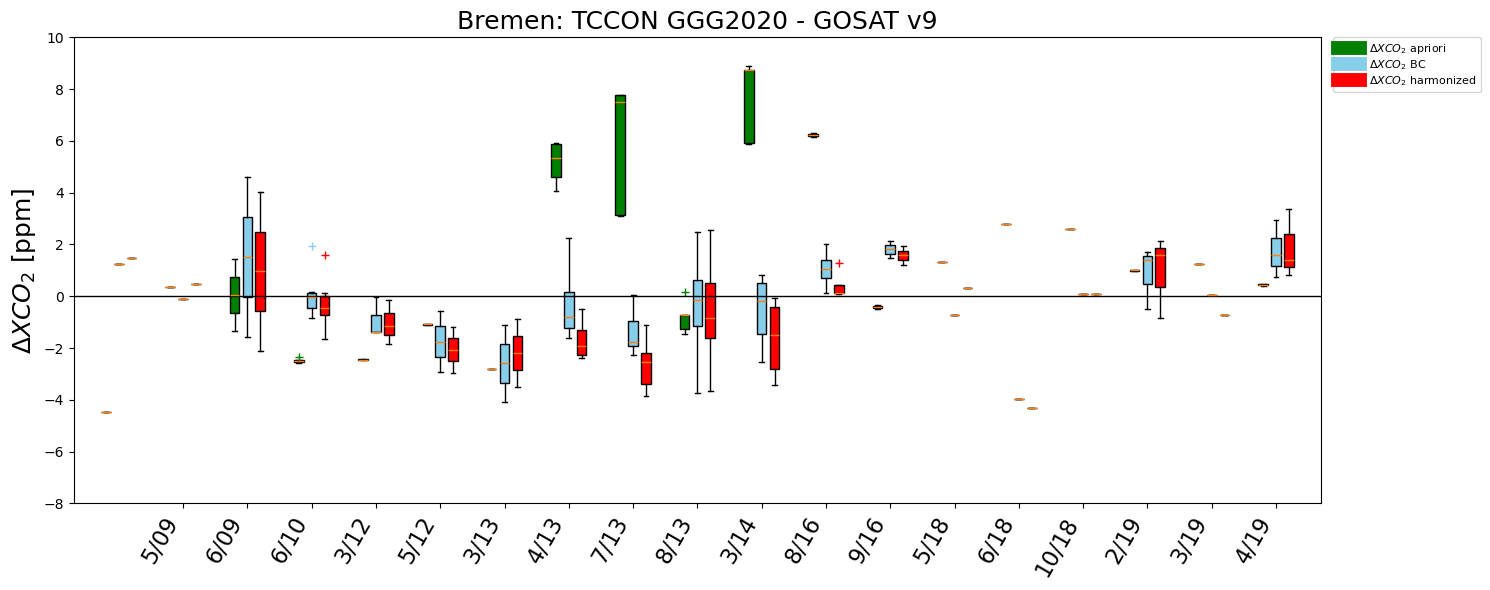

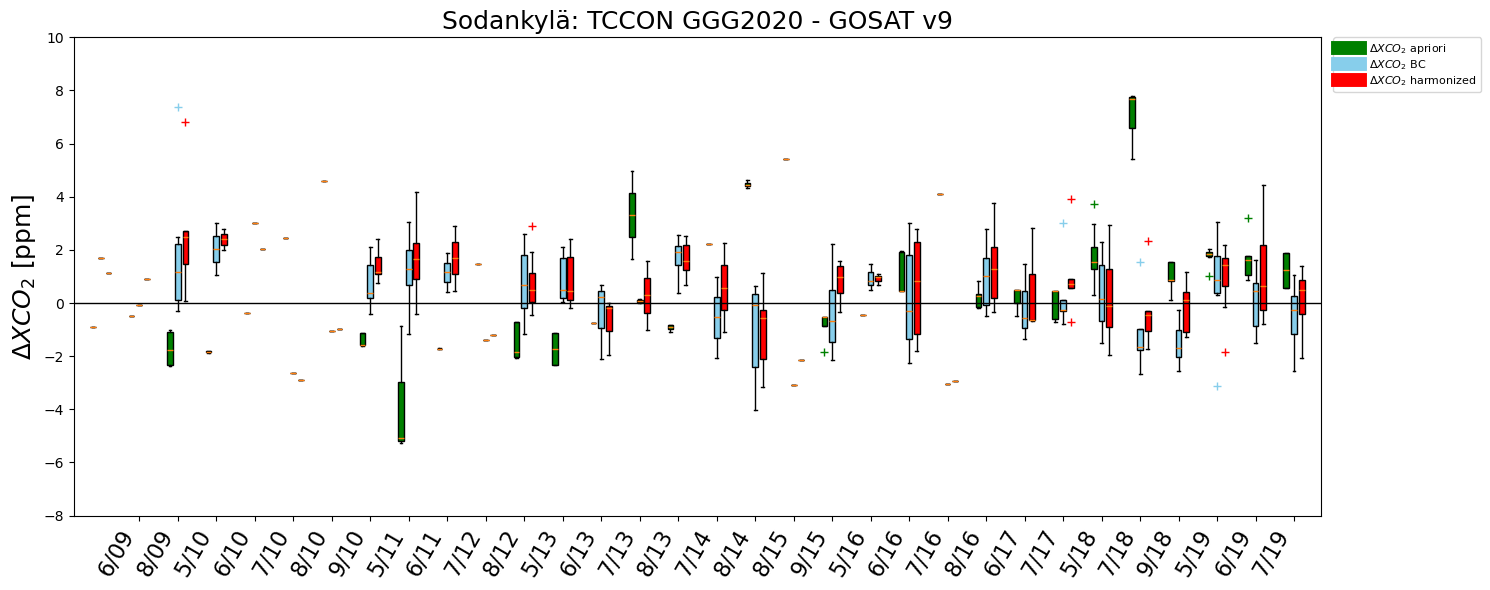

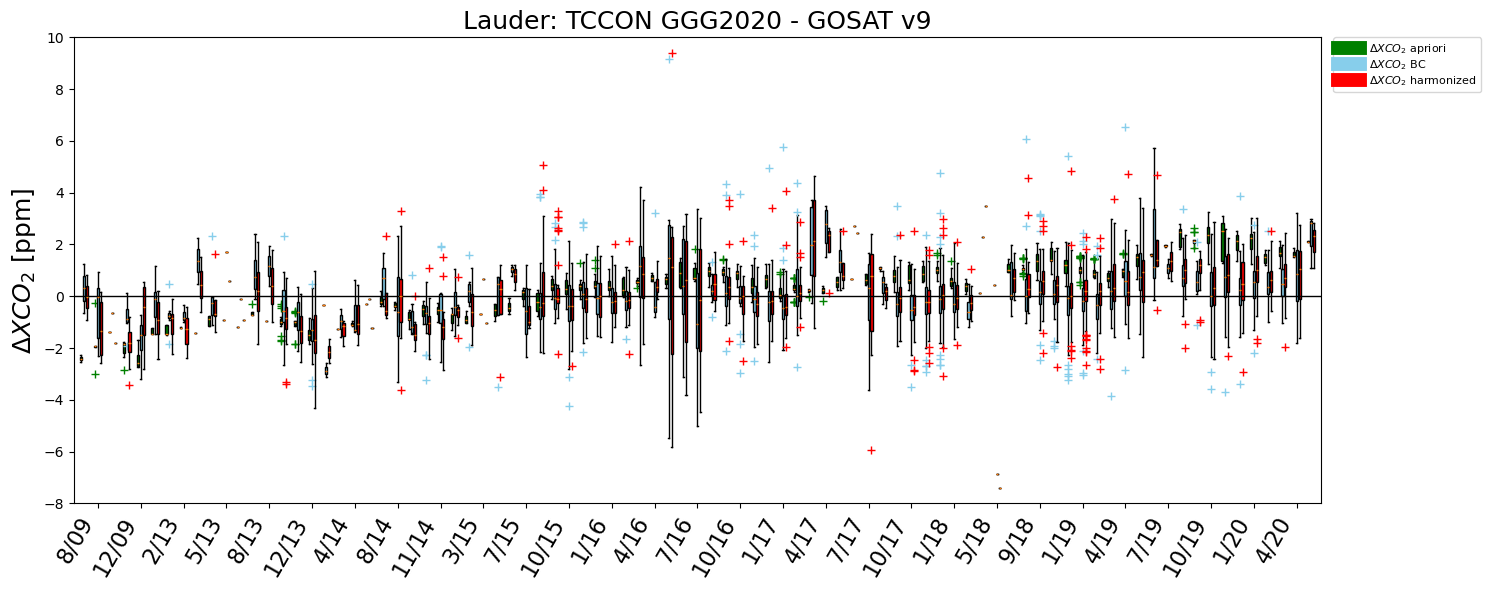

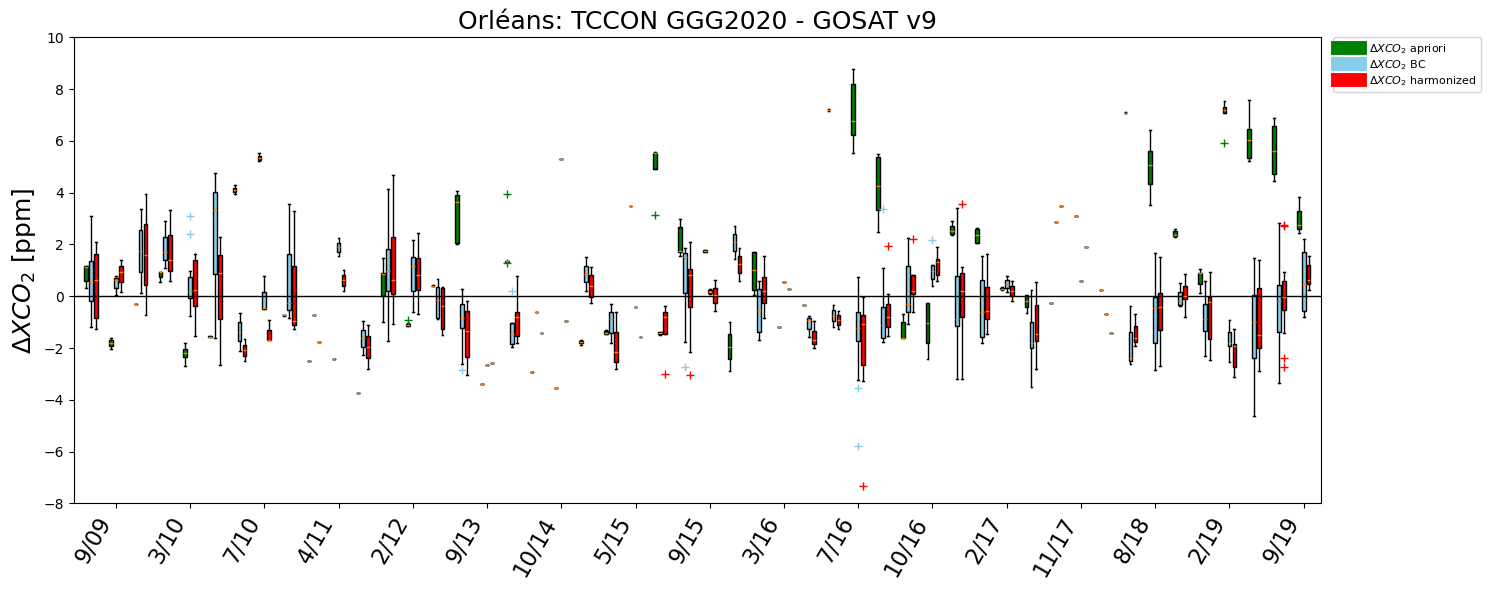

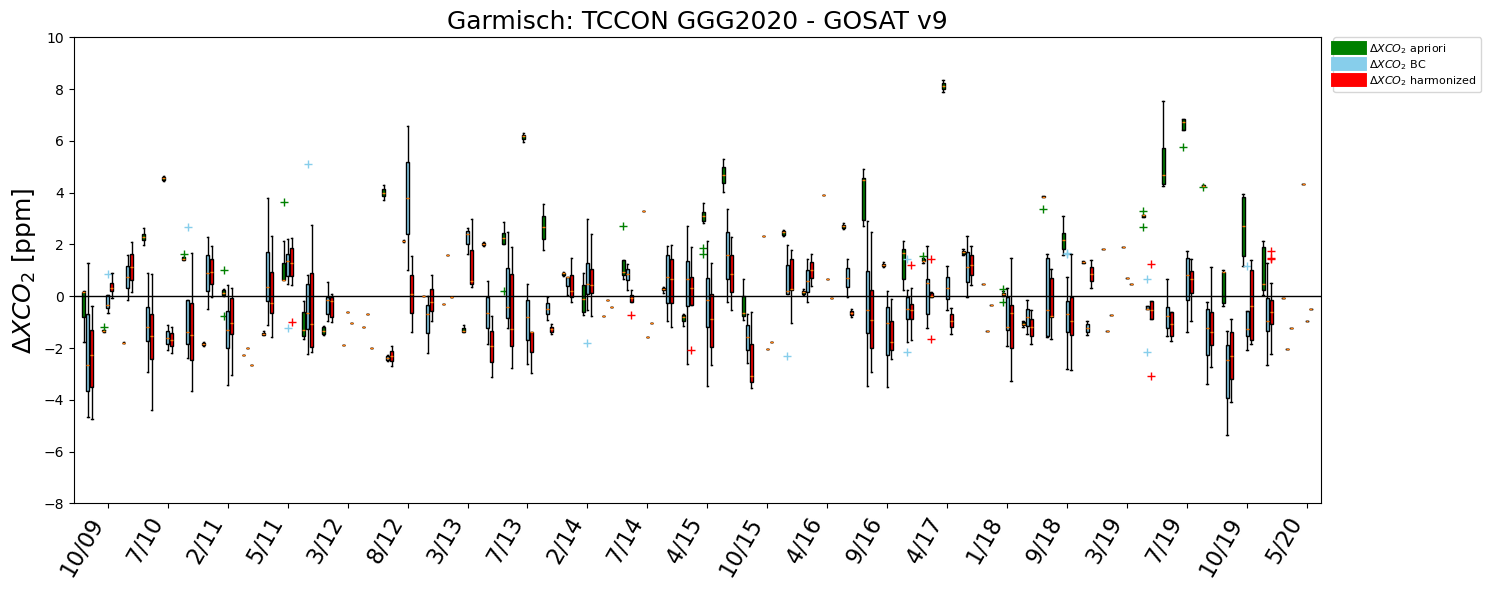

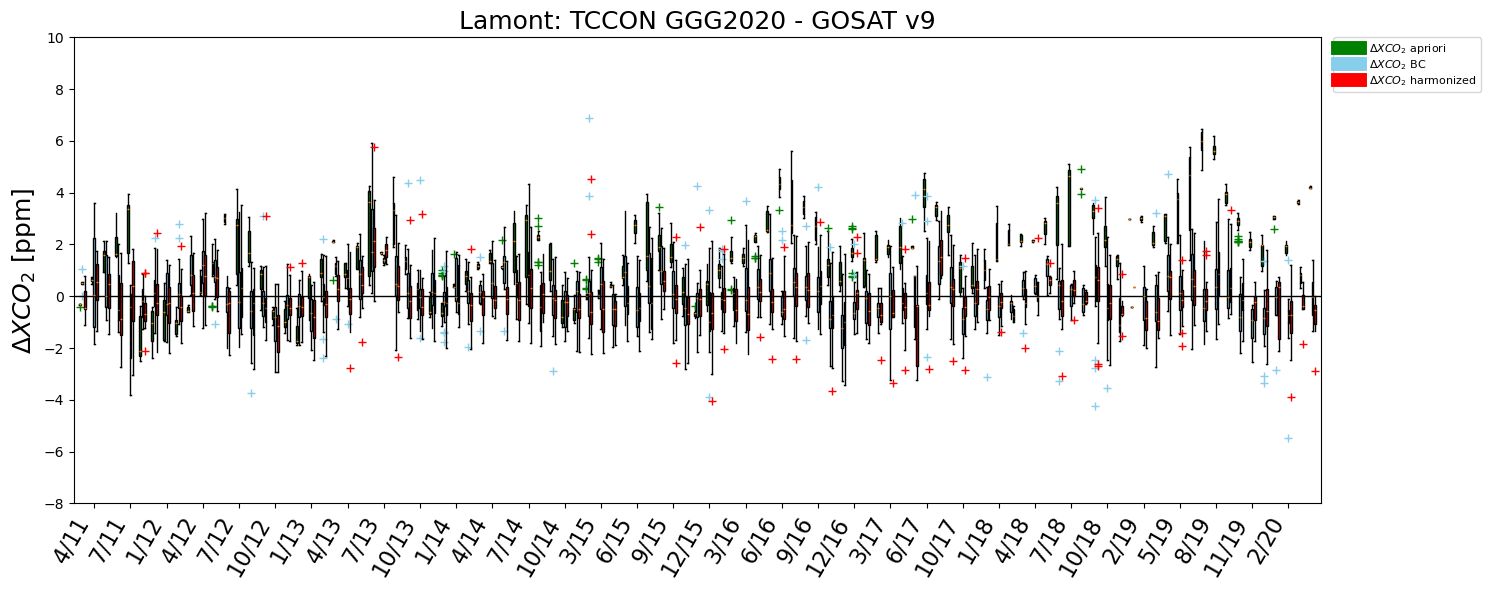

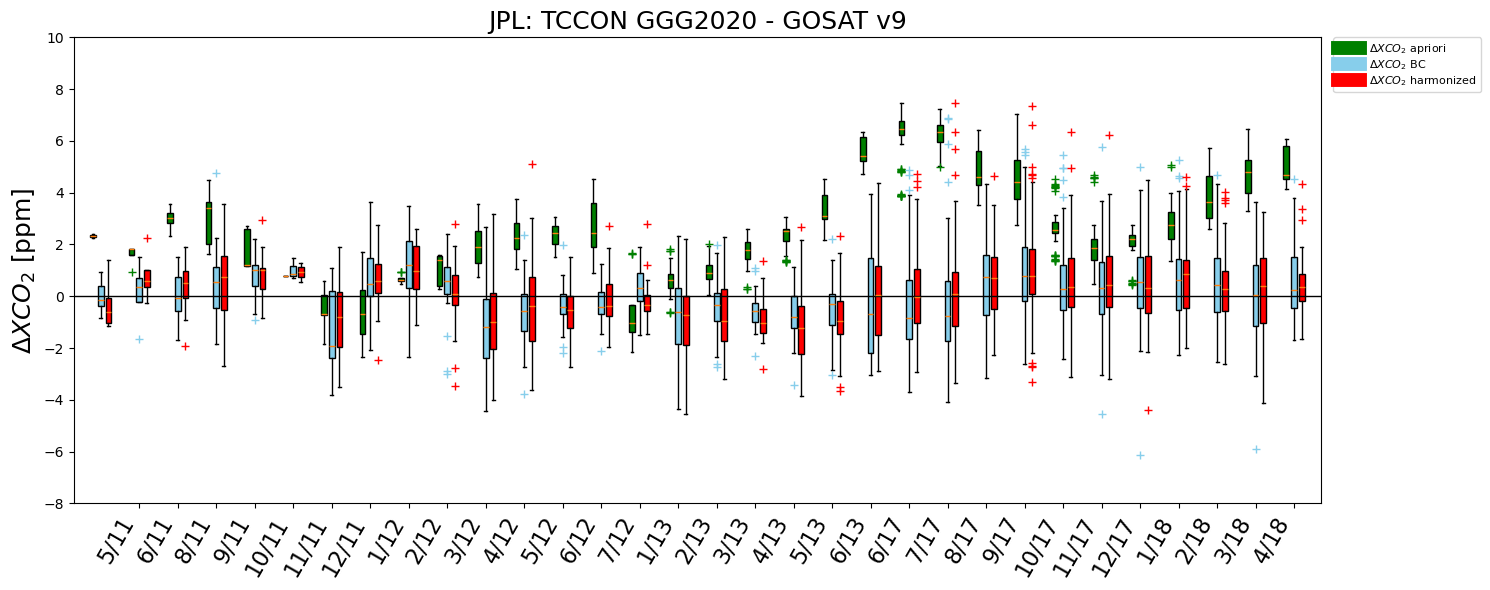

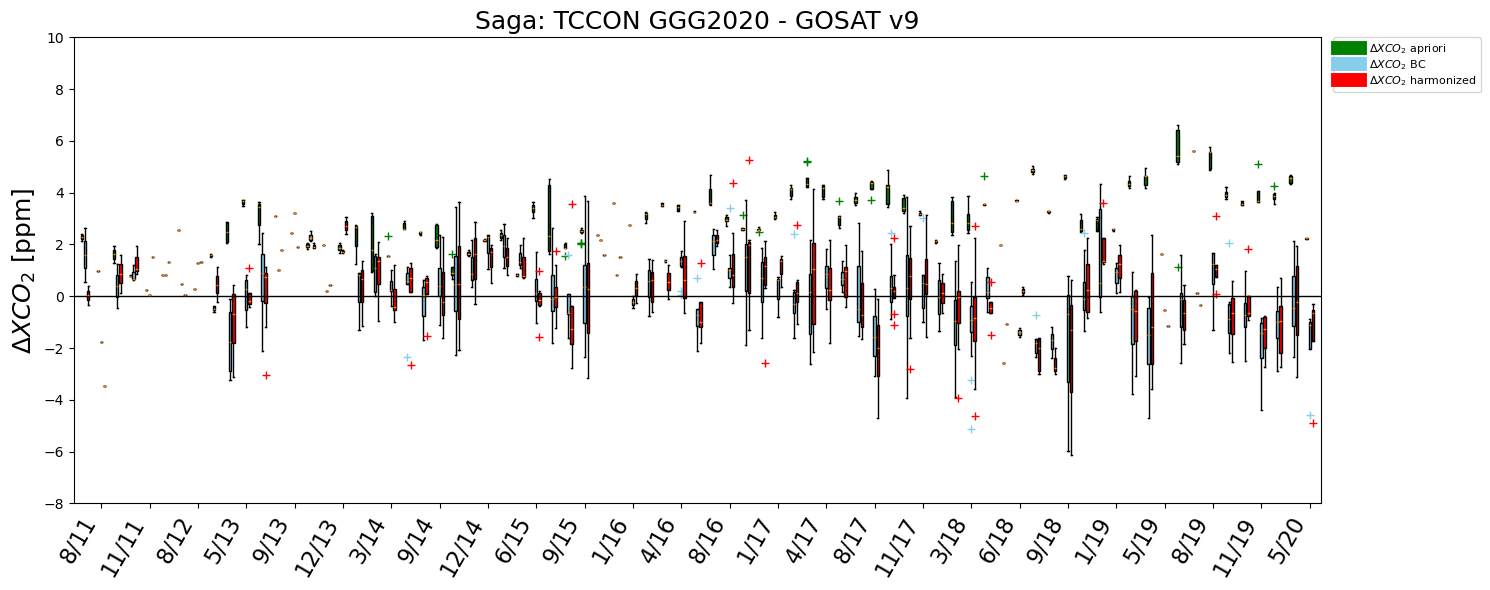

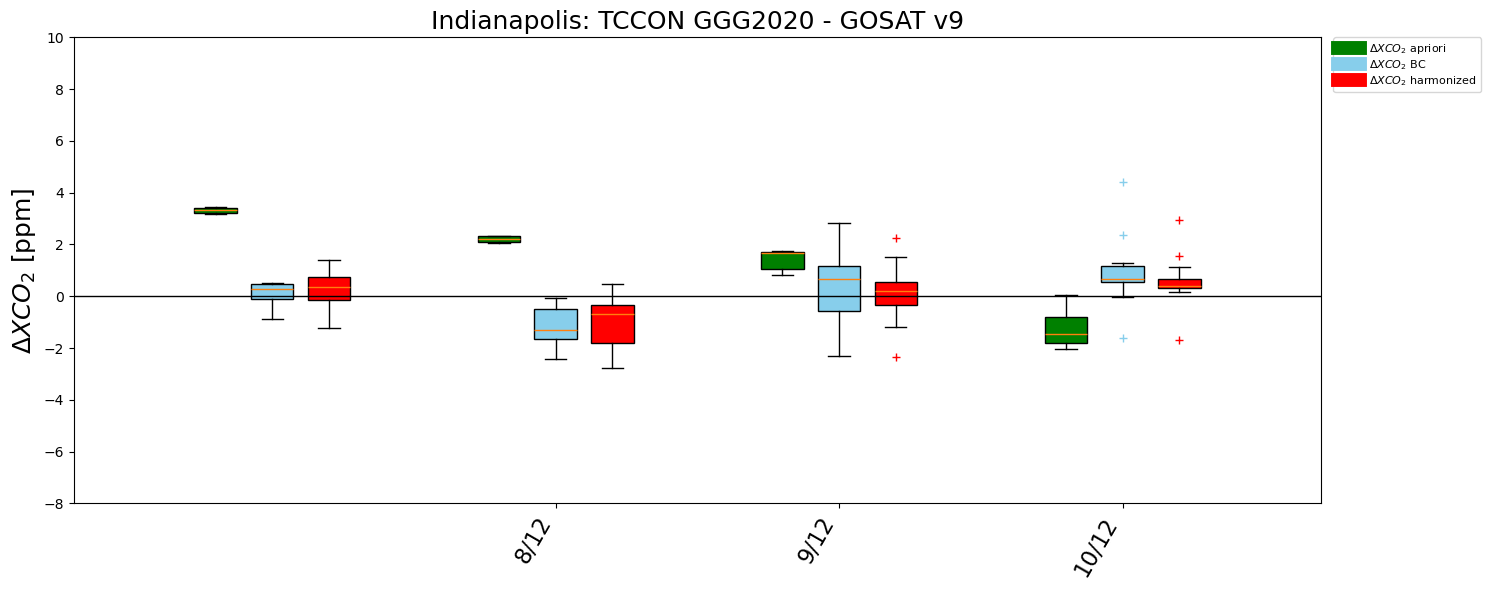

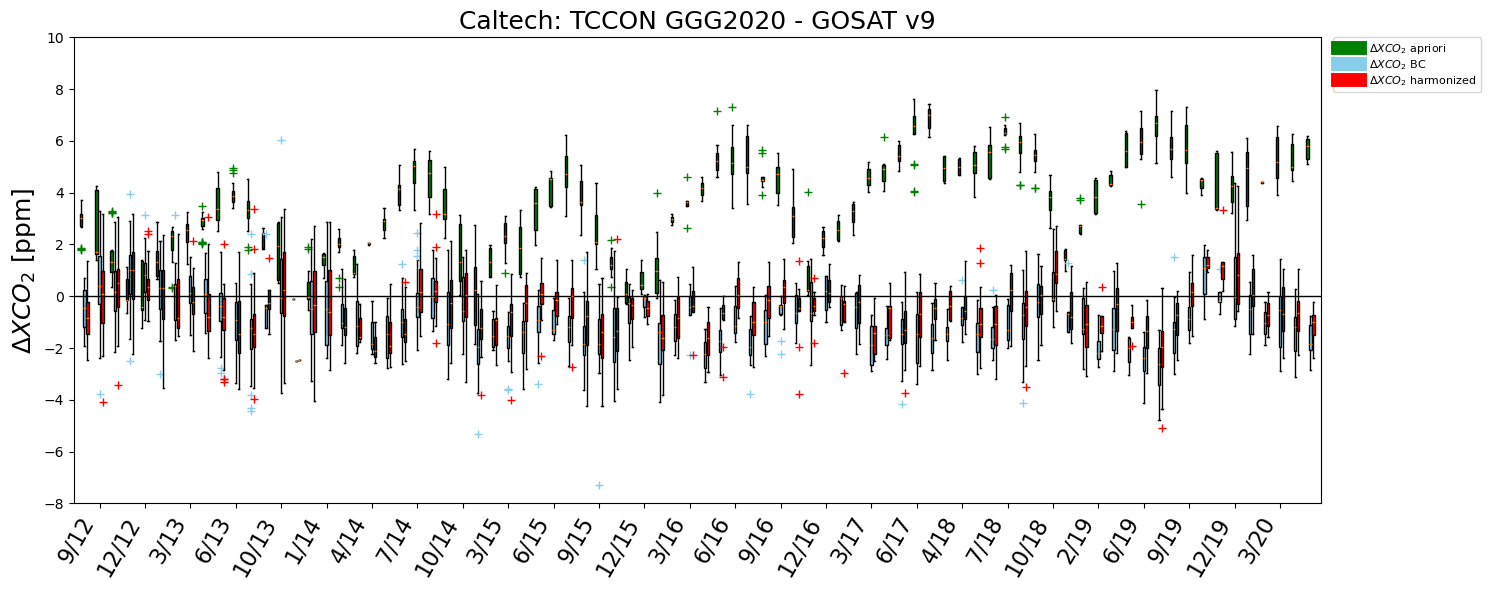

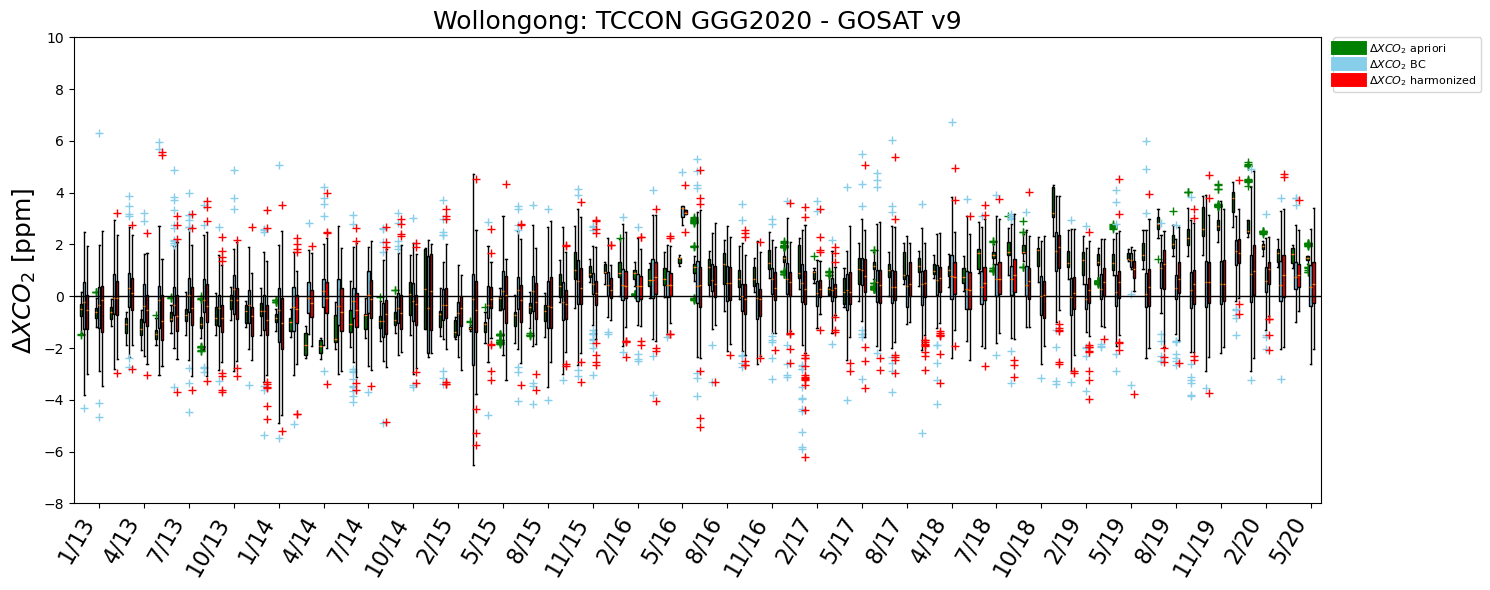

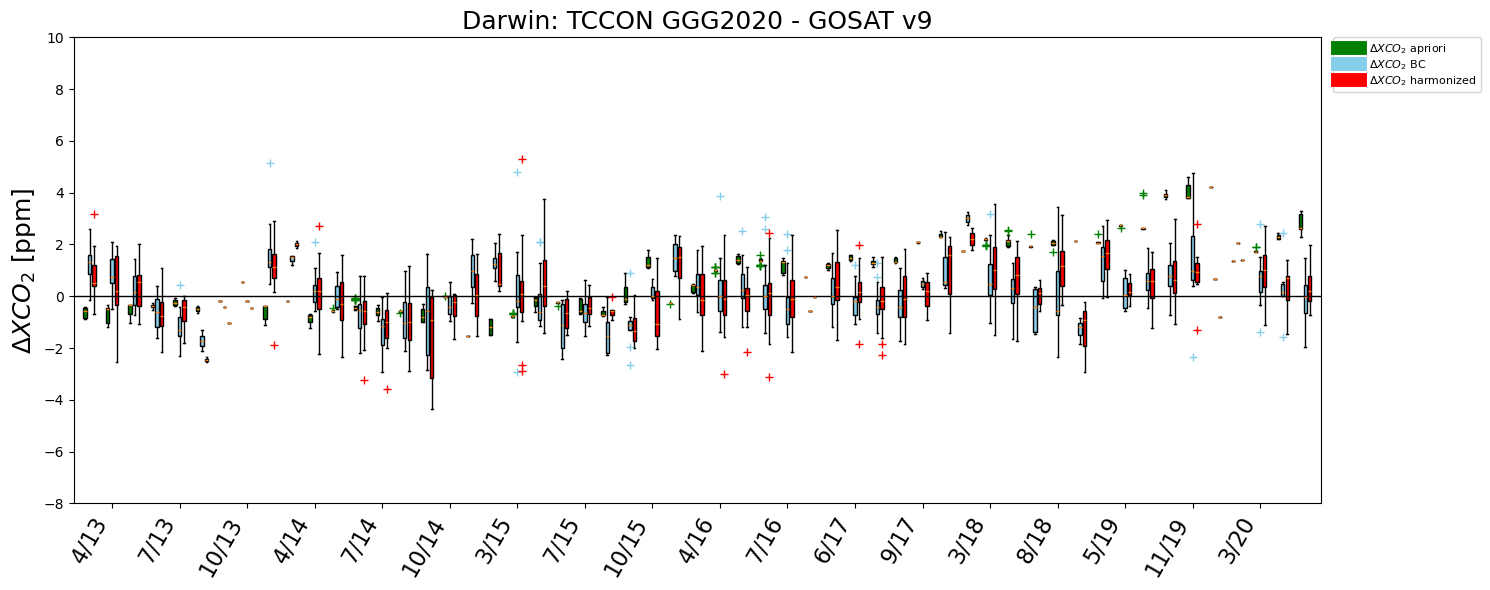

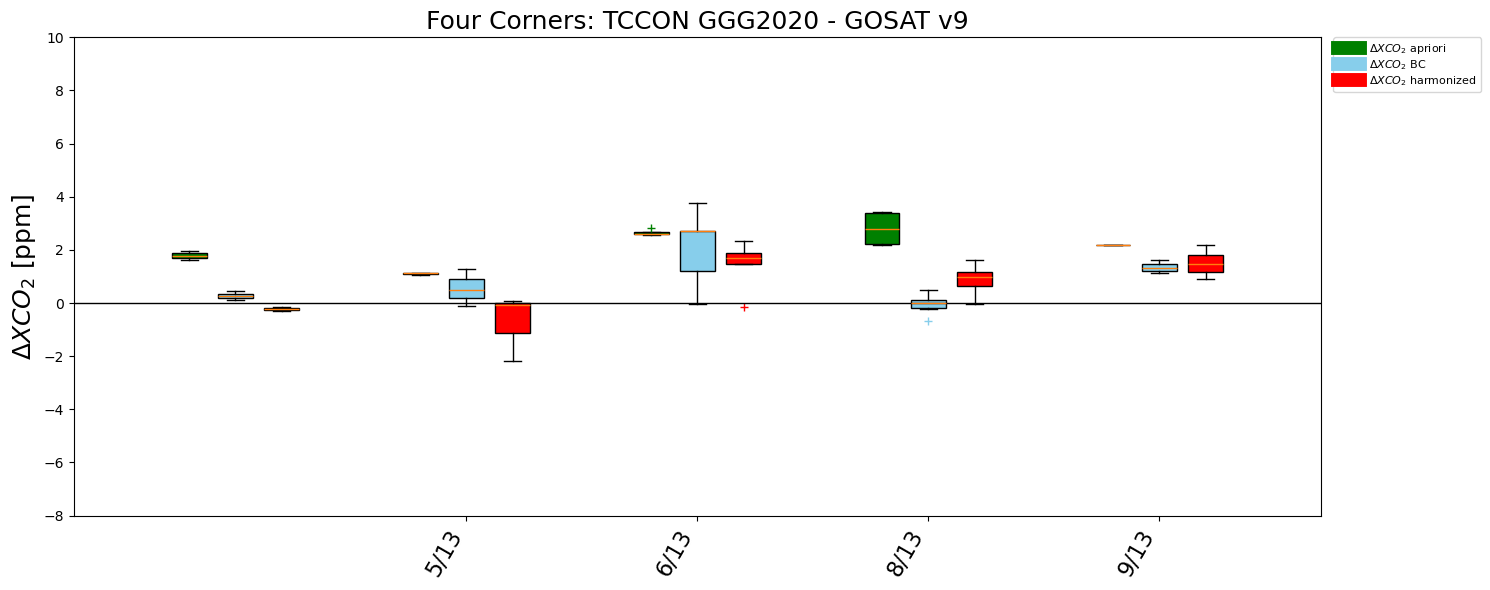

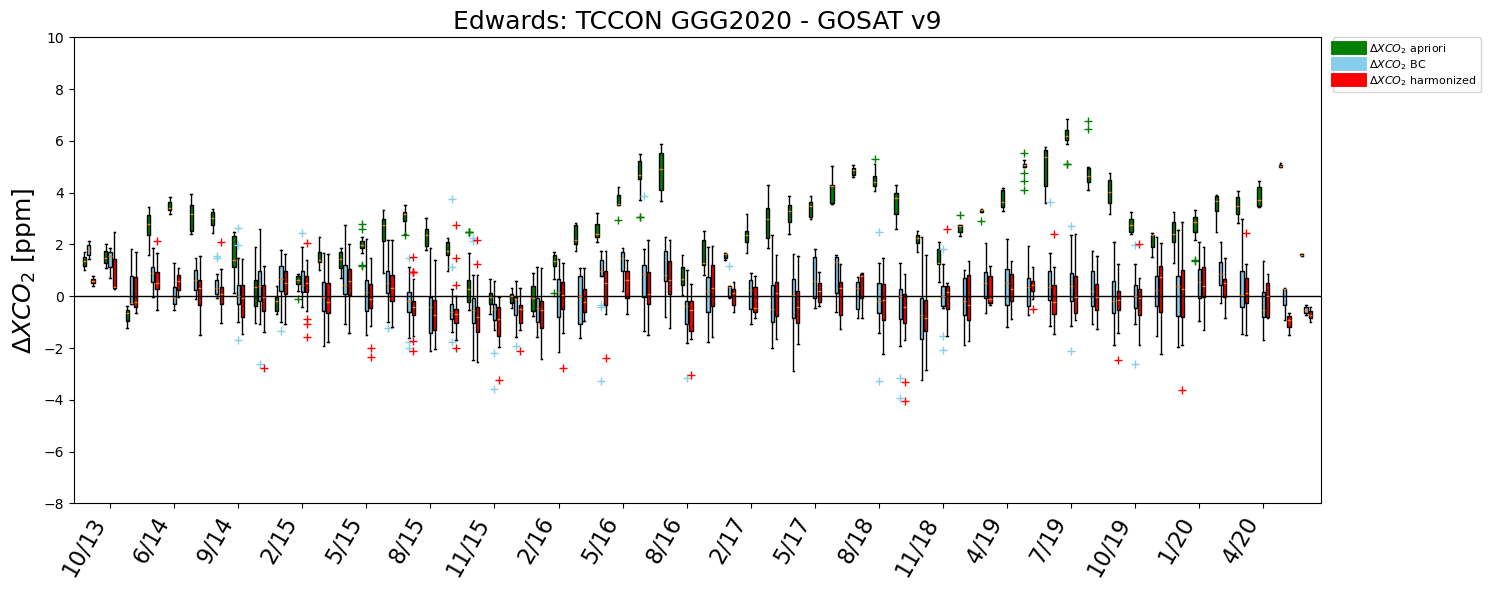

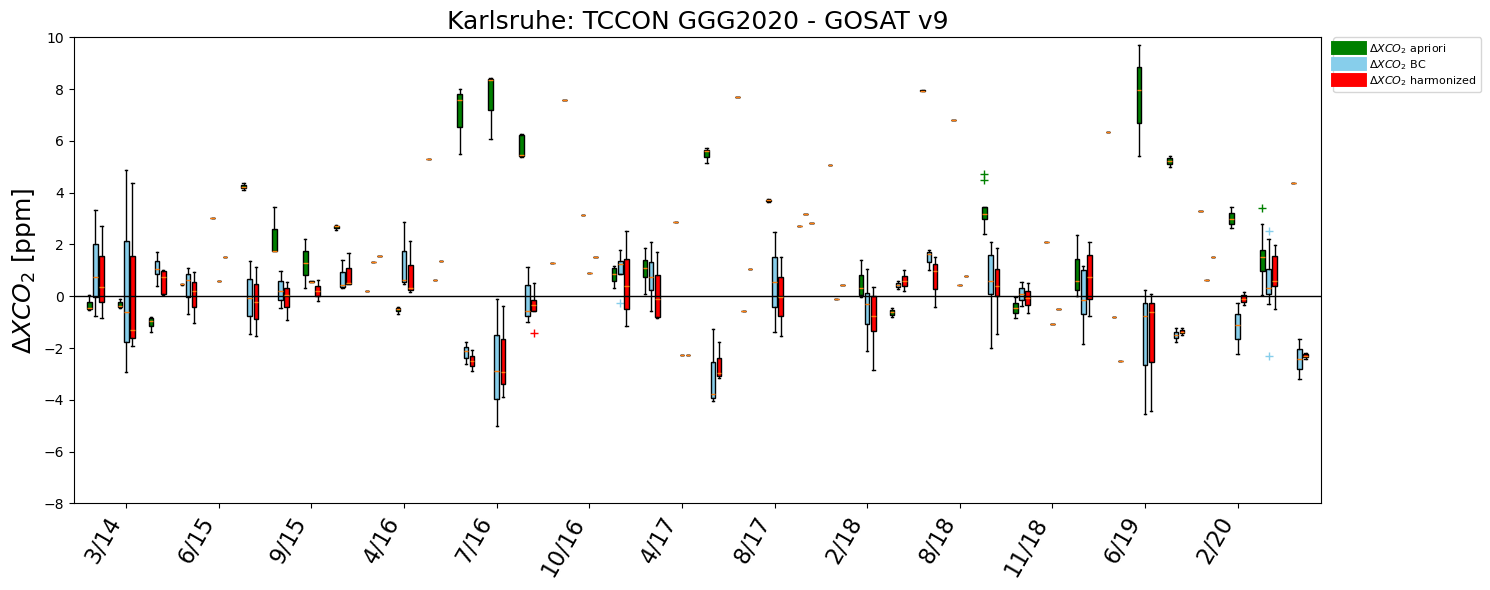

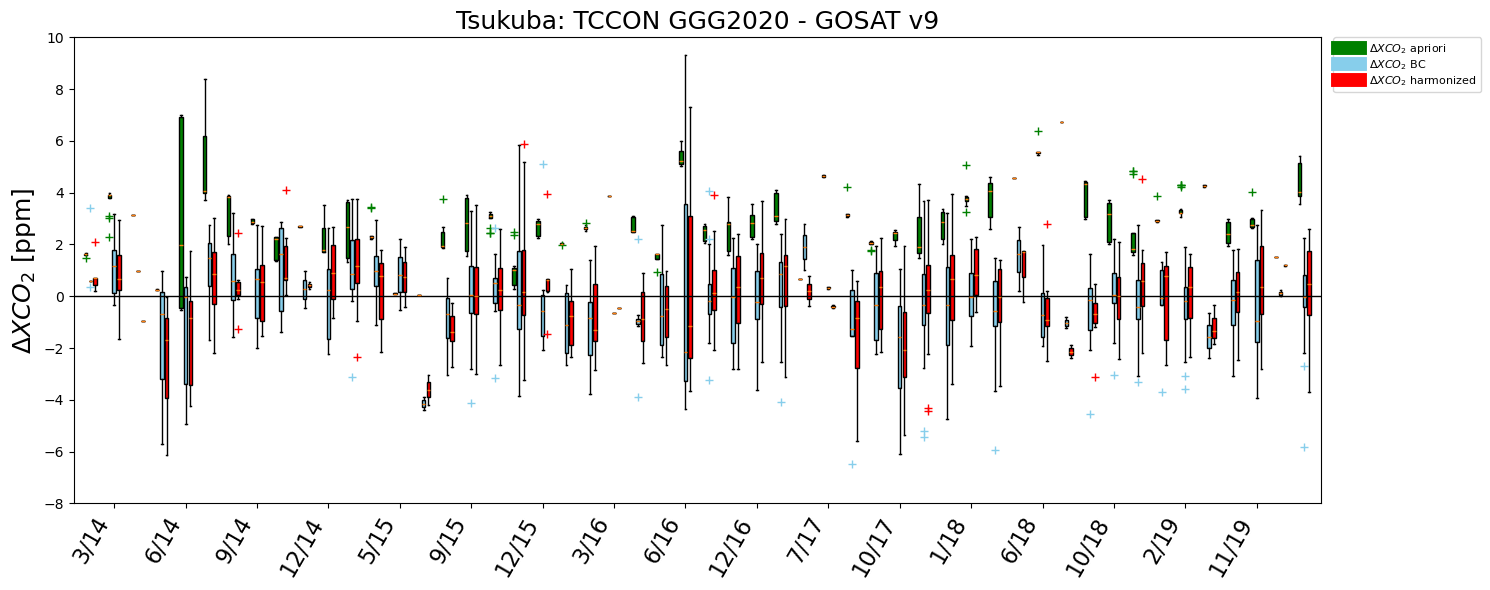

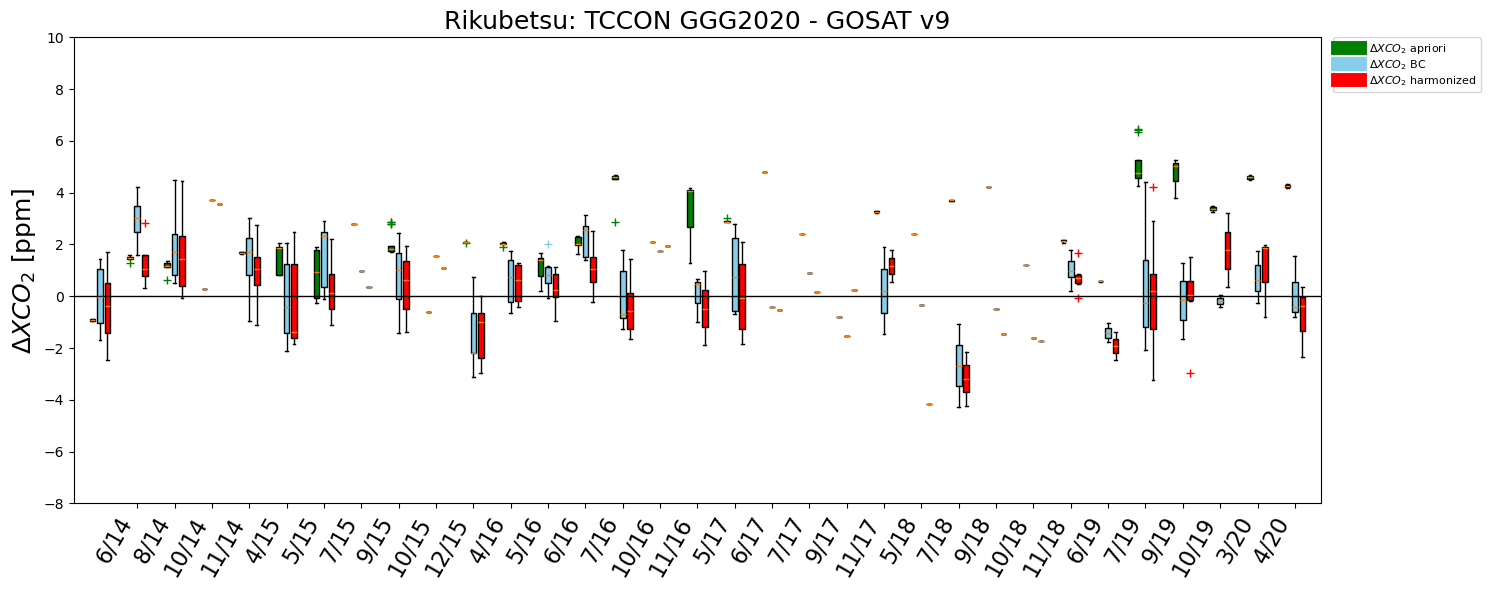

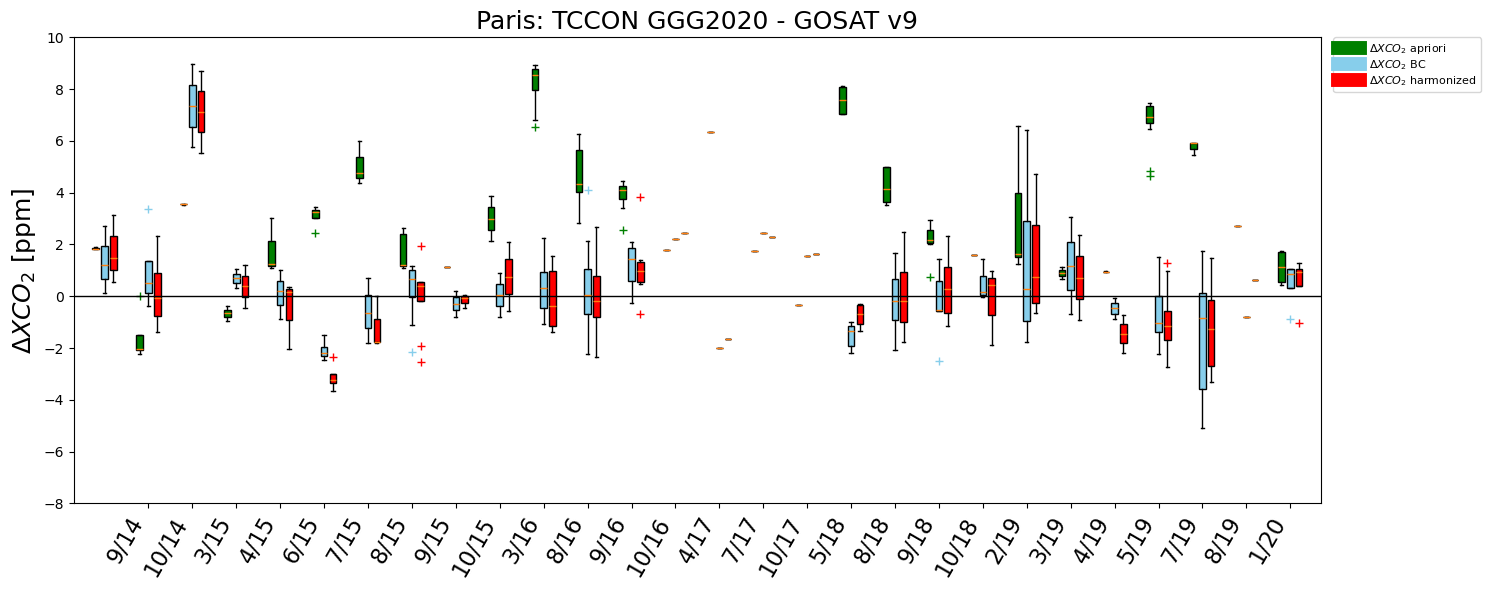

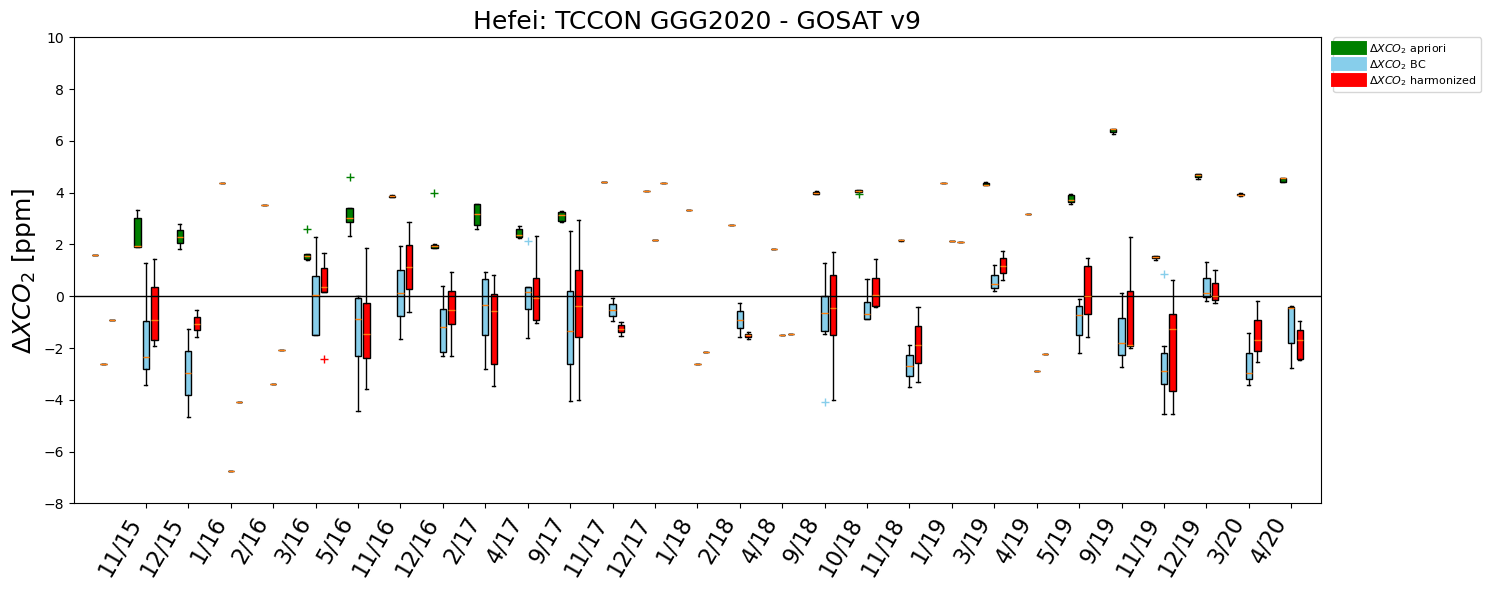

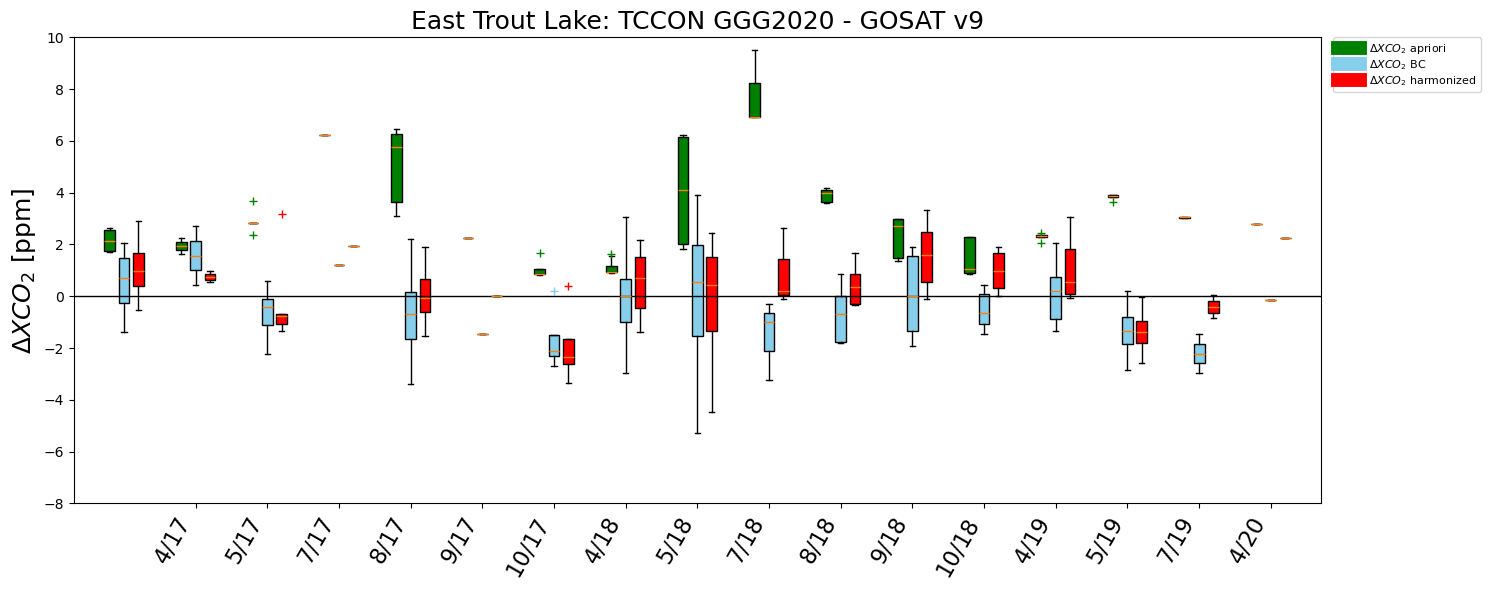

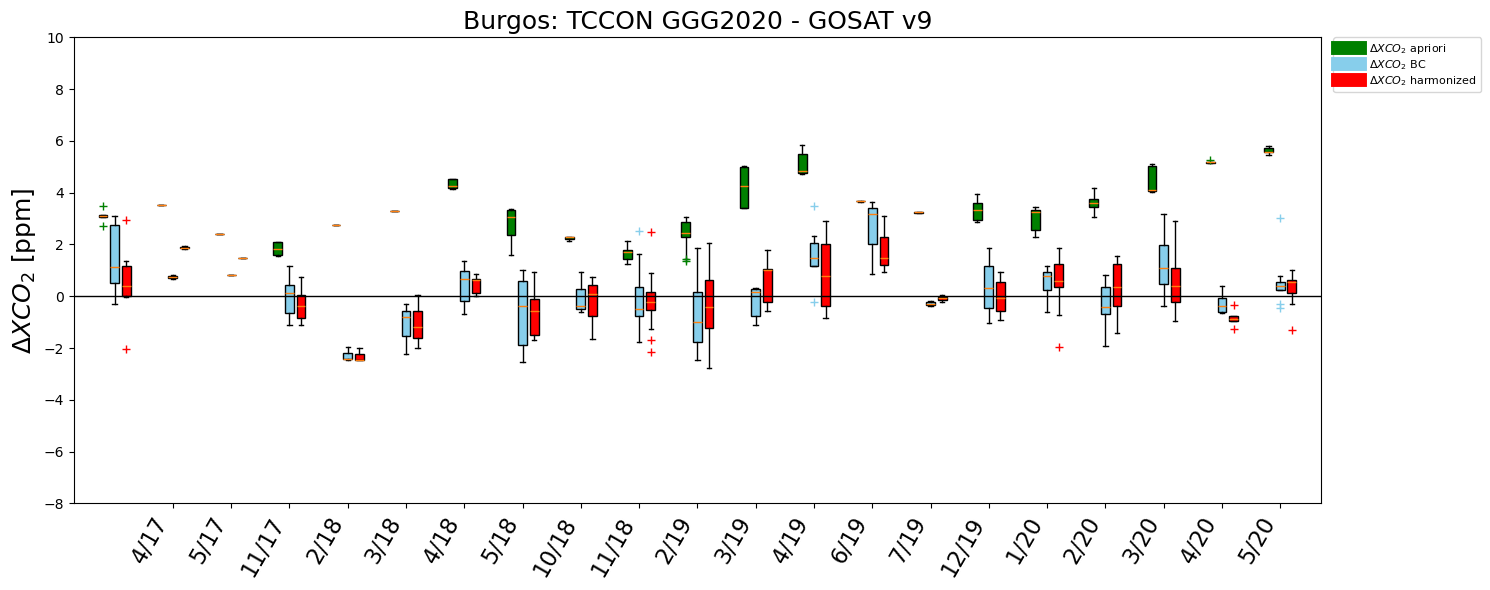

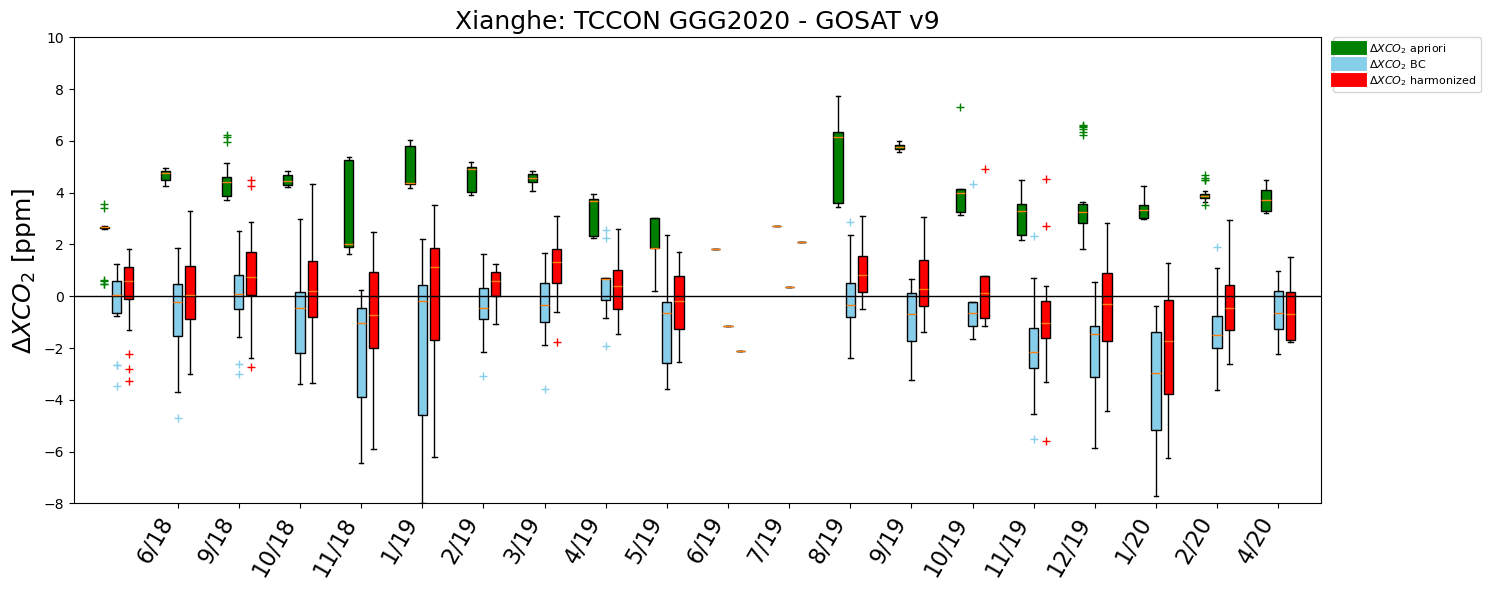

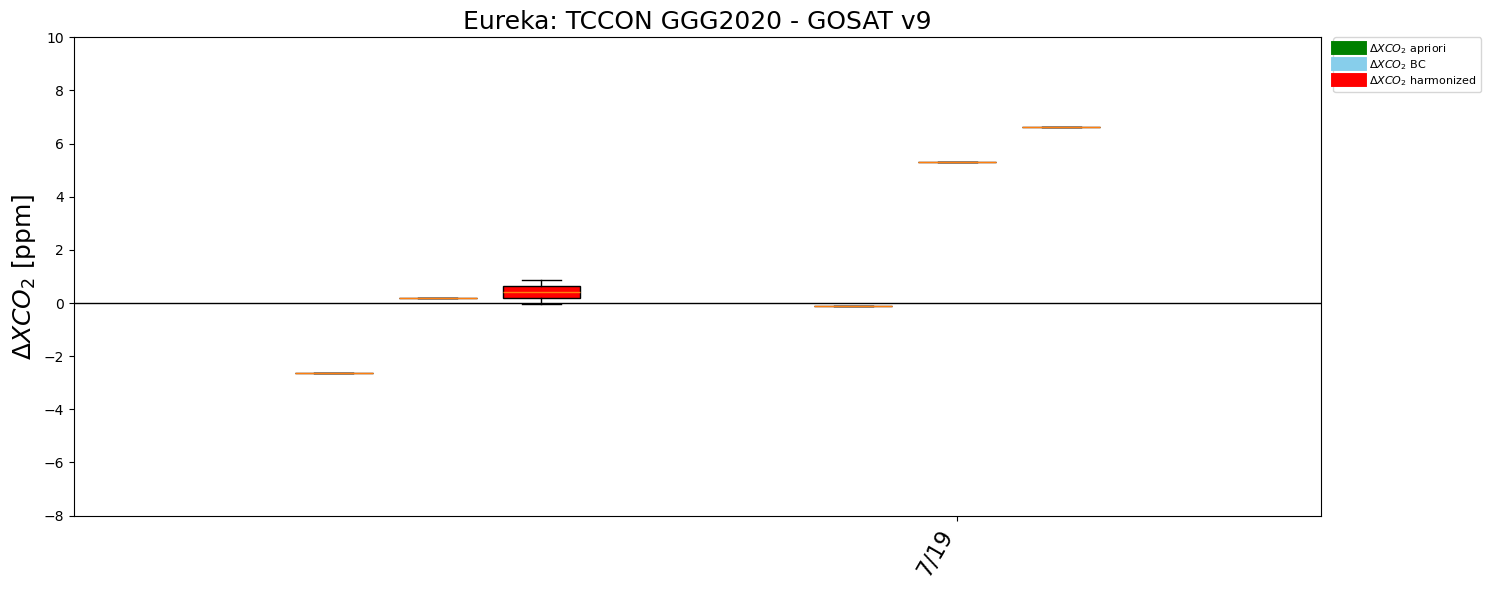

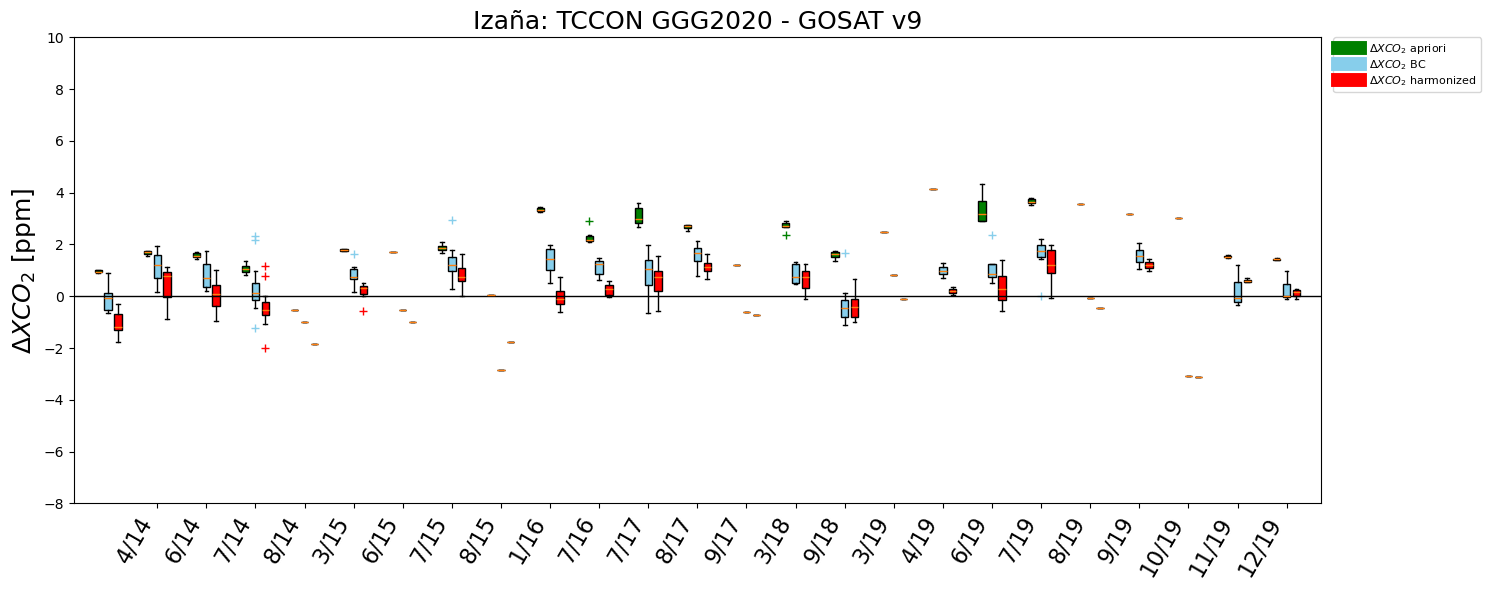

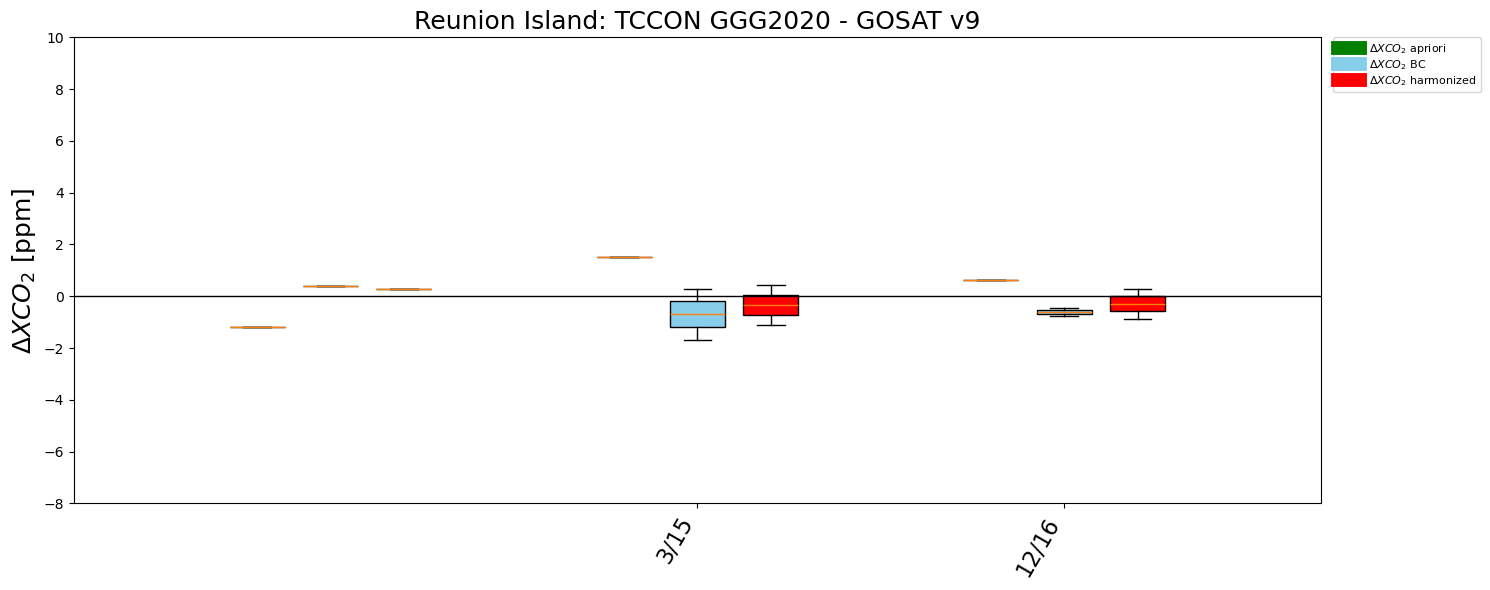

In [161]:
# Per site box & whisker plots -- AUTOMATIC SCALNG OF X-AXIS 

plot_dir = 'C:\\Users\\hopki\\Projects\\gosat_oco2\\plots\\tccon_monthly\\'

tccon_gosat_collocations['year_month_str'] = tccon_gosat_collocations['gosat_year'].astype(str) + tccon_gosat_collocations['gosat_month'].astype(str)

categories = ['gosat_xco2_apriori','gosat_xco2','gosat_xco2_harmonized']
colors = {'gosat_xco2_apriori':'green', 'gosat_xco2':'skyblue', 'gosat_xco2_harmonized':'red'}

for site in tccon_gosat_collocations['tccon_site'].unique():
    site_data = tccon_gosat_collocations[tccon_gosat_collocations['tccon_site']==site]

    if site_data.shape[0] == 0:
        continue
    fig, ax = plt.subplots(figsize=(15,6))

    positions = []
    pos = -1
    width = 0.2  # spacing between grouped boxes

    #year_months = tccon_gosat_collocations['year_month_str'].unique()
    # iterate over each month over the full time series
    dates_with_data = []  # use this for xticklabels
    for year_month in year_months:
        year_month_data = site_data[site_data['year_month_str'] == year_month]
        if year_month_data.shape[0] == 0:
            continue
        dates_with_data += [year_month]
        #print(f'{year_month_data['gosat_year'].unique()} - {year_month_data['gosat_month'].unique()}')
        for i, cat in enumerate(categories):
            cat_data = year_month_data['tccon_xco2_ak_corrected_mean'] - year_month_data[cat]
            # Calculate position
            positions.append(pos + i*width - width)
            bp = ax.boxplot(cat_data, positions=[pos + i*width - width],
                            widths=0.15, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor(colors[cat])
            for flier in bp['fliers']:
                flier.set_markeredgecolor(colors[cat])
                flier.set_marker('+')
        pos += 1 # position for where to plot b&w

    # X-axis labels
    """ax.set_xticks(dates_list_to_keep)
    ax.set_xticklabels(dates_list_friendly, rotation=60, ha='right', fontsize=16)  
    ax.set_xlim(0,len(x_labels_dict)+1)   
    """# X-axis labels
    dates_with_data_friendly = [str(date)[4:] + '/' + str(date)[2:4] for date in dates_with_data]
    if len(dates_with_data) < 40:  # display all dates
        ax.set_xticks(range(len(dates_with_data)))
        # transform dates_with_data into more user-friendly format
        ax.set_xticklabels(dates_with_data_friendly, rotation=60, ha='right', fontsize=16)
    else:
        tick_locs = np.arange(0,len(dates_with_data), 3)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(np.array(dates_with_data_friendly)[tick_locs], rotation=60, ha='right', fontsize=16)
    
    
    ax.axhline(0, color='k', linewidth=1)
    ax.set_ylim(-8,10)
    
    # Legend
    for cat in categories:
        ax.plot([], c=colors[cat], label=cat, linewidth=10)
    #ax.legend()
    legend = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., prop={'size': 8}, labelspacing=0.2)
    
    # Modify the legend texts
    legend_texts = legend.get_texts()
    legend_texts[0].set_text(r'$\Delta XCO_{2}$ apriori')
    legend_texts[1].set_text(r'$\Delta XCO_{2}$ BC')
    legend_texts[2].set_text(r'$\Delta XCO_{2}$ harmonized')
    
    ax.set_ylabel(r'$\Delta XCO_{2}$ [ppm]', fontsize=18)
    ax.set_title(f'{site}: TCCON GGG2020 - GOSAT v9', fontsize=18)
    
    plt.tight_layout()
    #plt.savefig(os.path.join(plot_dir, f'{site}_montly_tccon_to_gosat.png'), bbox_inches='tight')
    plt.show()